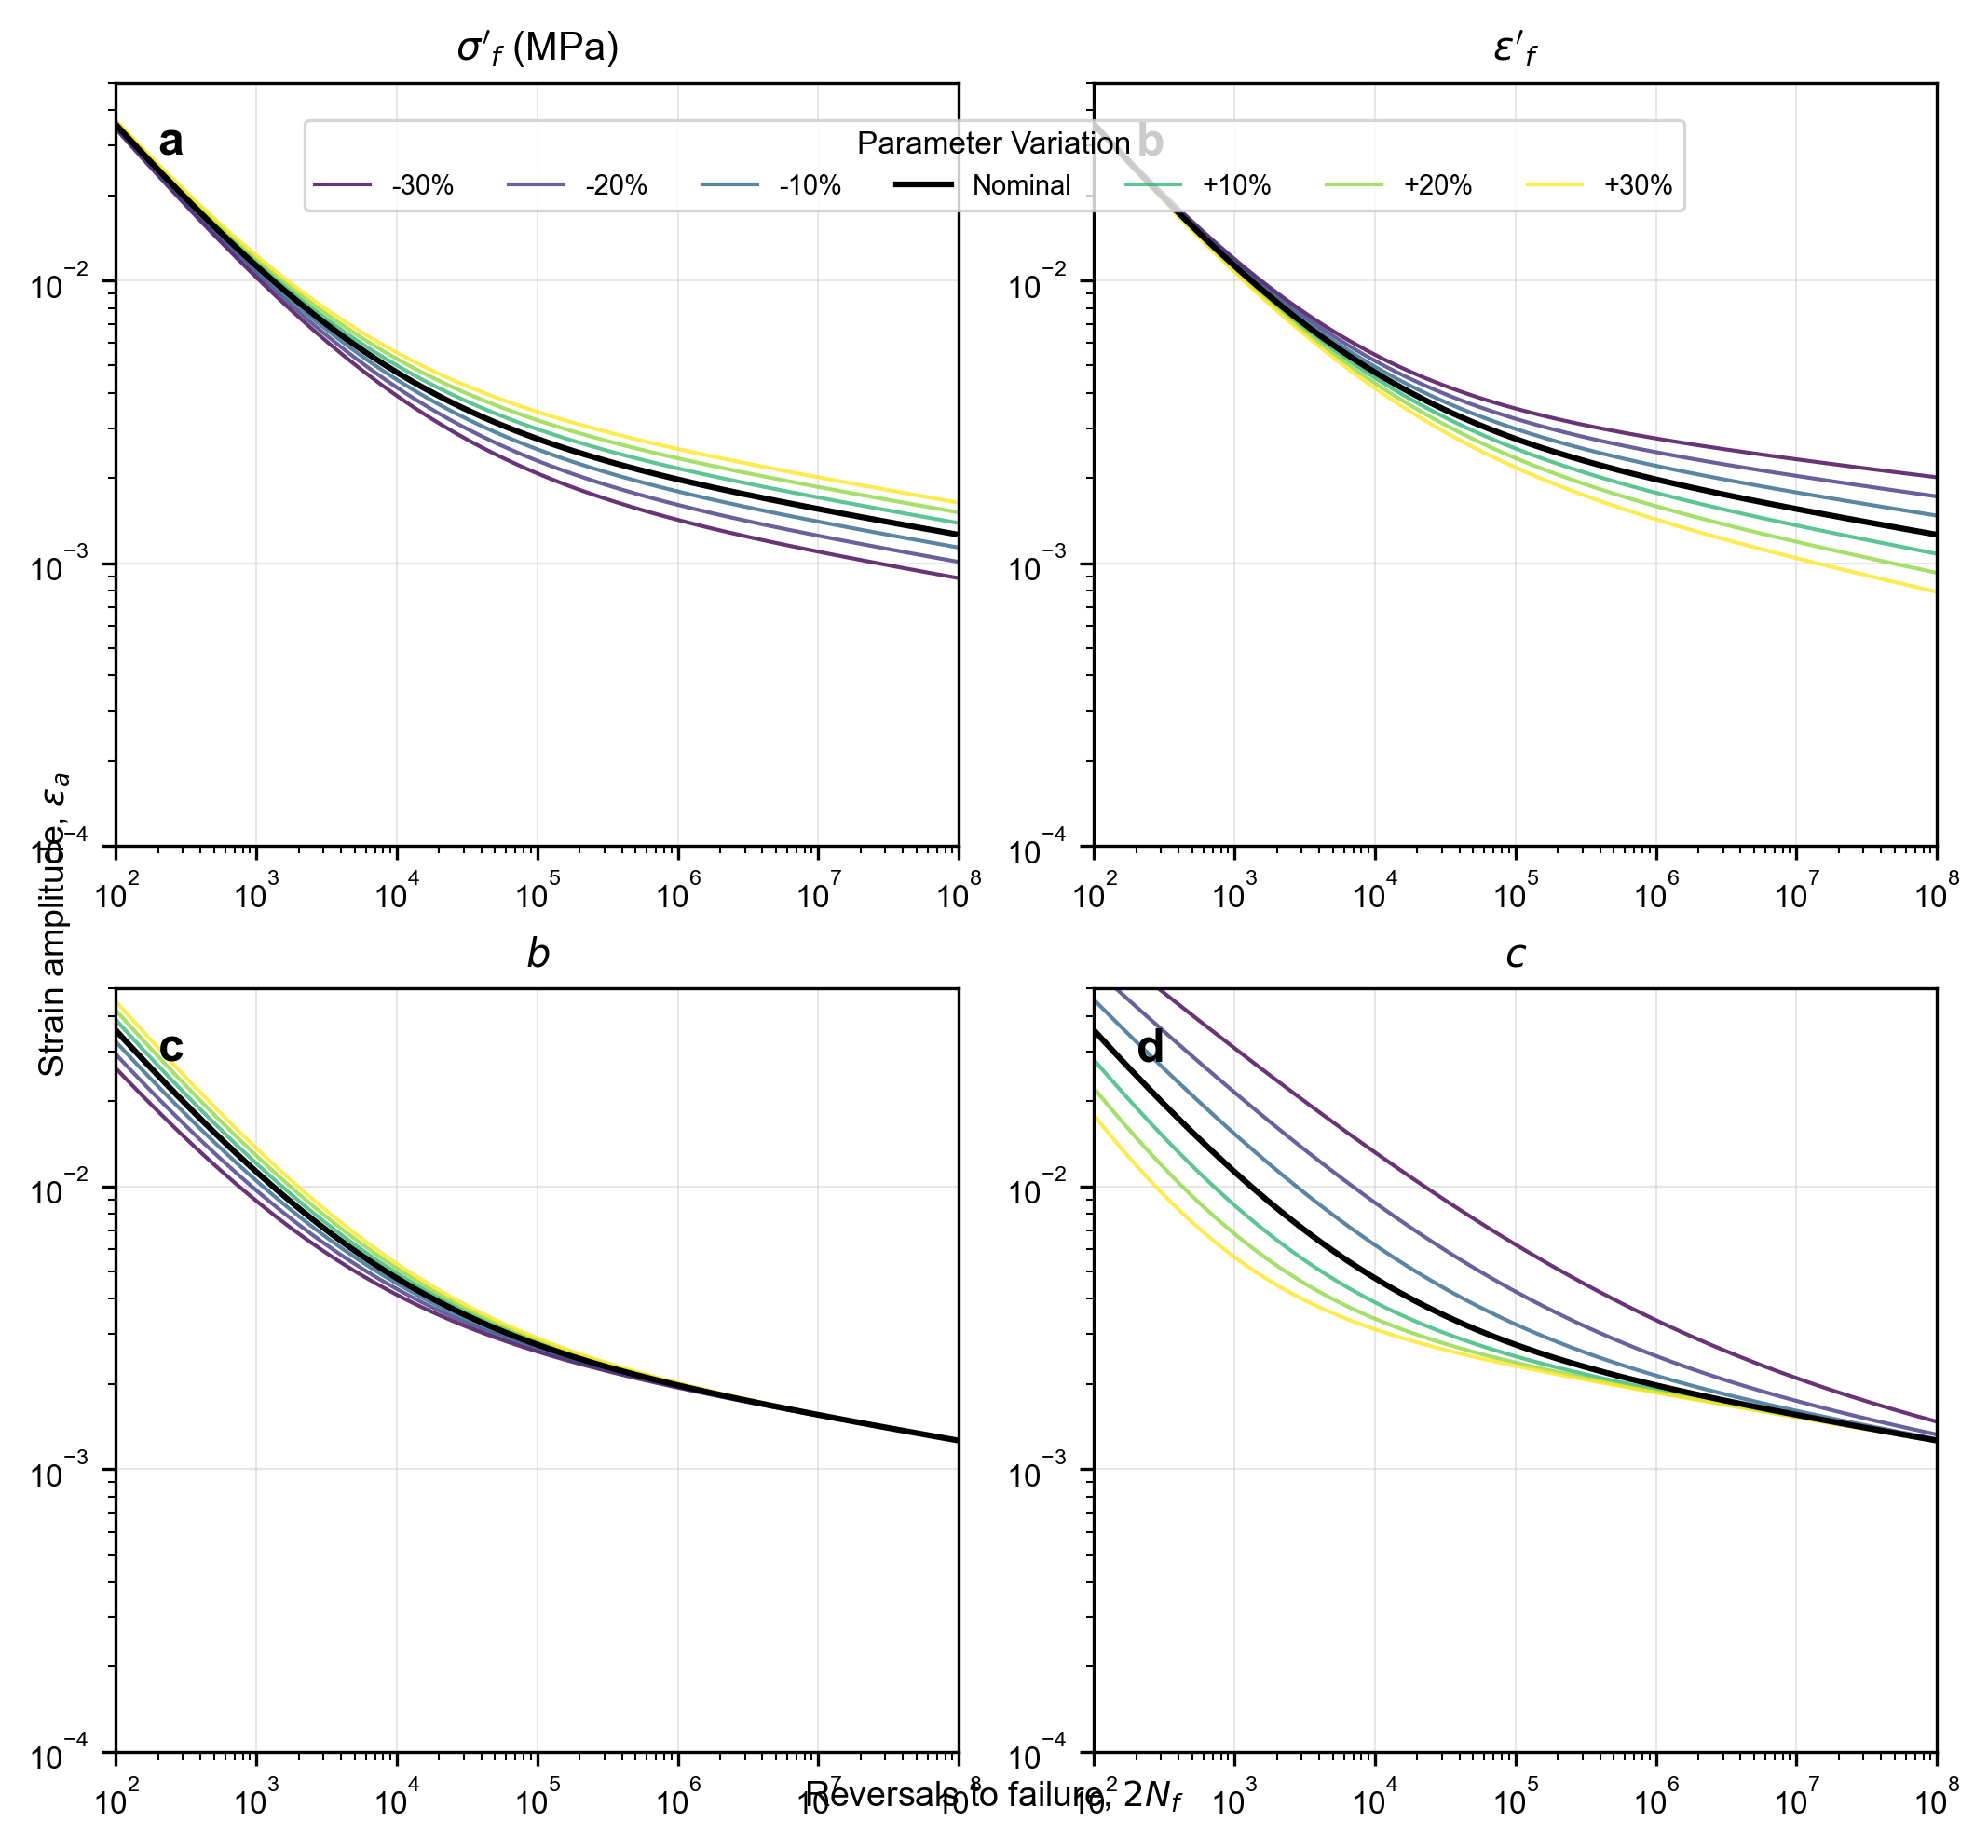



                                민감도 분석 수치 요약 결과                                 

--- sigma_f' 민감도에 따른 Strain Amplitude 범위 (-30% ~ 30%) ---
----------------------------------------------------------------------------------
  Target 2Nf |     Min Strain |     Max Strain |   Nominal Strain |   Strain Range
----------------------------------------------------------------------------------
     1.0e+03 |       0.010259 |       0.012261 |         0.011260 |       0.002001
     5.0e+03 |       0.005053 |       0.006799 |         0.005926 |       0.001745
     1.0e+04 |       0.003910 |       0.005556 |         0.004733 |       0.001646
     5.0e+04 |       0.002432 |       0.003867 |         0.003150 |       0.001435
     1.0e+05 |       0.002079 |       0.003432 |         0.002755 |       0.001353
     5.0e+05 |       0.001567 |       0.002747 |         0.002157 |       0.001180
     1.0e+06 |       0.001424 |       0.002536 |         0.001980 |       0.001113
     1.0e+07 |       0.00109

In [25]:
# Cell 0: spf, epf, b, c 민감도 분석 (Nature 스타일 2x2 플롯 및 수치 요약 강화)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import fsolve
import warnings

# --- [수정 1] Nature 저널 스타일 Matplotlib 전역 설정 ---
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['mathtext.fontset'] = 'dejavusans'
plt.rcParams['font.size'] = 8  # 기본 폰트 크기
plt.rcParams['axes.labelsize'] = 9  # 축 레이블
plt.rcParams['axes.titlesize'] = 10 # 서브플롯 제목
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['lines.linewidth'] = 1.0
plt.rcParams['axes.linewidth'] = 0.8 # 축 선 두께
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.constrained_layout.use'] = True # 레이아웃 자동 조정

# --- 기본 설정 및 공칭 파라미터 정의 ---
SPF_NOMINAL = 1200.0
B_NOMINAL = -0.085
EPF_NOMINAL = 0.50
C_NOMINAL = -0.60
E_MPA_NOMINAL = 200000.0
TARGET_2NF_LEVELS = np.array([1e3, 5e3, 1e4, 5e4, 1e5, 5e5, 1e6, 1e7])
DEFINED_STRAIN_AMPLITUDES = np.logspace(np.log10(0.001), np.log10(0.02), 50)

# --- Coffin-Manson 관련 함수들 (수정된 버전) ---
def calculate_strain_amplitude(params, E_val, two_Nf_target):
    """
    주어진 2Nf(스칼라 또는 배열)에서 변형률 진폭을 계산합니다.
    배열 입력에 대해 강건하게 동작하도록 수정되었습니다.
    """
    spf, b_exp, epf, c_exp = params
    
    # 스칼라 파라미터 유효성 검사
    if any(v is None for v in [spf, b_exp, epf, c_exp, E_val]) or np.isnan([spf, b_exp, epf, c_exp, E_val]).any():
        # 파라미터가 유효하지 않으면 입력 형태에 따라 nan 또는 nan 배열 반환
        return np.nan if np.isscalar(two_Nf_target) else np.full_like(np.asanyarray(two_Nf_target), np.nan, dtype=float)

    # 입력값을 항상 numpy 배열로 처리하여 벡터화 연산 준비
    two_Nf_array = np.asanyarray(two_Nf_target)
    
    # 계산 오류를 방지하기 위해 0 이하의 값을 nan으로 변경
    safe_two_Nf = np.where(two_Nf_array > 0, two_Nf_array, np.nan)

    try:
        # 벡터화된 Coffin-Manson 계산
        term1 = (spf / E_val) * np.power(safe_two_Nf, b_exp)
        term2 = epf * np.power(safe_two_Nf, c_exp)
        result = term1 + term2
        
        # 원래 입력이 스칼라였다면 결과도 스칼라로 반환
        return result.item() if np.isscalar(two_Nf_target) else result
        
    except (OverflowError, ValueError):
        # 예외 발생 시 입력 형태에 맞춰 nan 또는 nan 배열 반환
        return np.nan if np.isscalar(two_Nf_target) else np.full_like(two_Nf_array, np.nan, dtype=float)

# --- [수정 2] 모든 파라미터의 민감도를 2x2 그리드에 플로팅하는 마스터 함수 ---
def plot_all_sensitivities_2x2(nominal_values, E_mpa, percentage_changes, 
                               strain_amplitudes_for_curve, target_2Nf_for_error_analysis):
    """4개 파라미터 민감도 분석을 하나의 2x2 플롯에 그리고, 분석 데이터를 반환합니다."""
    
    param_configs = {
        'spf': {'label': r"$\sigma'_f$ (MPa)", 'ax_pos': (0, 0), 'panel_label': 'a'},
        'epf': {'label': r"$\varepsilon'_f$", 'ax_pos': (0, 1), 'panel_label': 'b'},
        'b':   {'label': r"$b$", 'ax_pos': (1, 0), 'panel_label': 'c'},
        'c':   {'label': r"$c$", 'ax_pos': (1, 1), 'panel_label': 'd'}
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(7, 6.5)) # 레전드 공간을 위해 높이 증가
    all_dfs = {}
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(percentage_changes)))

    for param_name, config in param_configs.items():
        ax = axes[config['ax_pos']]
        all_sensitivity_data = []
        
        nominal_params_list = list(nominal_values)
        param_idx = list(param_configs.keys()).index(param_name)
        
        # 각 파라미터 값 변화에 따른 곡선 플롯
        for i, p_change in enumerate(percentage_changes):
            current_params = list(nominal_params_list)
            varied_val = current_params[param_idx] * (1 + p_change / 100.0)
            current_params[param_idx] = varied_val
            
            # 곡선 데이터 생성 (계산 간소화)
            reversals_for_plot = np.logspace(2, 8, 100)
            strains_for_plot = calculate_strain_amplitude(current_params, E_mpa, reversals_for_plot)
            
            # 공칭값(0% 변화)은 검정색으로 강조
            if p_change == 0:
                ax.plot(reversals_for_plot, strains_for_plot, color='black', linewidth=1.5, label='Nominal', zorder=10)
            else:
                ax.plot(reversals_for_plot, strains_for_plot, color=colors[i], alpha=0.8, label=f"{p_change:+d}%")

            # 수치 분석용 데이터 생성
            for t_2Nf in target_2Nf_for_error_analysis:
                strain_at_t_2Nf = calculate_strain_amplitude(current_params, E_mpa, t_2Nf)
                all_sensitivity_data.append({'param_change_percent': p_change, 'target_2Nf': t_2Nf, 
                                             'strain_amplitude_calc': strain_at_t_2Nf})
        
        all_dfs[param_name] = pd.DataFrame(all_sensitivity_data)
        
        # 서브플롯 스타일링
        ax.set_xscale('log'); ax.set_yscale('log')
        ax.grid(True, which="major", ls="-", alpha=0.3, linewidth=0.5)
        ax.set_xlim(1e2, 1e8); ax.set_ylim(1e-4, 5e-2)
        ax.set_title(config['label'], loc='center')
        ax.text(0.05, 0.95, config['panel_label'], transform=ax.transAxes, 
                fontsize=12, fontweight='bold', va='top')

    # 범례는 그림 맨 위에 하나로 통합
    handles, labels = axes[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=len(percentage_changes), title='Parameter Variation')

    # 공통 축 레이블 설정
    fig.text(0.5, 0.02, r'Reversals to failure, $2N_f$', ha='center', va='center', fontsize=9)
    fig.text(0.02, 0.5, r'Strain amplitude, $\varepsilon_a$', ha='center', va='center', rotation='vertical', fontsize=9)
    
    plt.show()
    return all_dfs['spf'], all_dfs['epf'], all_dfs['b'], all_dfs['c']


# --- [수정 3] 민감도 요약 테이블 출력 함수 (Strain Range 추가) ---
def print_sensitivity_summary(df_sensitivity, param_name, nominal_value_str, variation_range):
    """민감도 분석 결과를 요약하여 표로 출력합니다."""
    if df_sensitivity.empty:
        print(f"\n--- {param_name}에 대한 민감도 요약 결과 없음 ---")
        return

    # 공칭값일 때의 변형률 계산
    nominal_params = [SPF_NOMINAL, B_NOMINAL, EPF_NOMINAL, C_NOMINAL]
    df_sensitivity['strain_amplitude_nominal'] = df_sensitivity['target_2Nf'].apply(lambda x: calculate_strain_amplitude(nominal_params, E_MPA_NOMINAL, x))

    summary = df_sensitivity.groupby('target_2Nf').agg(
        min_strain=('strain_amplitude_calc', 'min'),
        max_strain=('strain_amplitude_calc', 'max'),
        nominal_strain=('strain_amplitude_nominal', 'first')
    ).reset_index()
    
    # Strain Range 계산
    summary['strain_range'] = summary['max_strain'] - summary['min_strain']

    print(f"\n--- {param_name} 민감도에 따른 Strain Amplitude 범위 ({variation_range[0]}% ~ {variation_range[-1]}%) ---")
    
    header = f"{'Target 2Nf':>12s} | {'Min Strain':>14s} | {'Max Strain':>14s} | {'Nominal Strain':>16s} | {'Strain Range':>14s}"
    print("-" * len(header))
    print(header)
    print("-" * len(header))
    for _, row in summary.iterrows():
        print(f"{row['target_2Nf']:>12.1e} | {row['min_strain']:>14.6f} | {row['max_strain']:>14.6f} | {row['nominal_strain']:>16.6f} | {row['strain_range']:>14.6f}")
    print("-" * len(header))


# --- 메인 실행 부분 ---
if __name__ == "__main__":
    nominal_fatigue_params = [SPF_NOMINAL, B_NOMINAL, EPF_NOMINAL, C_NOMINAL]
    param_variation_percentages = [-30, -20, -10, 0, 10, 20, 30]

    # 2x2 플롯 생성 및 데이터프레임 반환
    df_spf, df_epf, df_b, df_c = plot_all_sensitivities_2x2(
        nominal_values=nominal_fatigue_params,
        E_mpa=E_MPA_NOMINAL,
        percentage_changes=param_variation_percentages,
        strain_amplitudes_for_curve=DEFINED_STRAIN_AMPLITUDES,
        target_2Nf_for_error_analysis=TARGET_2NF_LEVELS
    )
    
    # 최종 수치 요약 결과 출력
    print("\n\n" + "="*80)
    print("민감도 분석 수치 요약 결과".center(80))
    print("="*80)
    
    print_sensitivity_summary(df_spf, "sigma_f'", f"{SPF_NOMINAL:.1f} MPa", param_variation_percentages)
    print_sensitivity_summary(df_epf, "epsilon_f'", f"{EPF_NOMINAL:.3f}", param_variation_percentages)
    print_sensitivity_summary(df_b, "b", f"{B_NOMINAL:.4f}", param_variation_percentages)
    print_sensitivity_summary(df_c, "c", f"{C_NOMINAL:.4f}", param_variation_percentages)

In [3]:
# Cell 1: 라이브러리 임포트 및 설정
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import fsolve
import warnings
from sklearn.metrics import r2_score, mean_squared_error
import joblib # 스케일러 및 target_cols 로드용
import seaborn as sns # palette 로드용

# Times New Roman 폰트 설정 등 (main0605.ipynb Cell 13과 동일하게)
mpl.rcParams.update({
    'font.family': 'serif', 'font.serif': 'Times New Roman', 'font.size': 12,
    'axes.labelsize': 20, 'axes.titlesize': 14, 'legend.fontsize': 10,
    'xtick.labelsize': 11, 'ytick.labelsize': 11, 'lines.linewidth': 1.8,
    'axes.grid': True, 'grid.alpha': 0.3, 'figure.dpi': 300,
    'axes.unicode_minus': False
})

# 색상 팔레트 (main0605.ipynb Cell 10과 동일하게)
# palette = sns.color_palette("colorblind")
# 또는 직접 지정
palette = [(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), # blue
           (0.8901960784313725, 0.10196078431372549, 0.10980392156862745), # red
           (0.21568627450980393, 0.6078431372549019, 0.3058823529411765),  # green
           (0.5058823529411764, 0.4470588235294118, 0.6980392156862745),  # purple
           (0.9921568627450981, 0.5529411764705883, 0.23529411764705882), # orange
           (0.6, 0.6, 0.6)] # grey for other lines if needed

print("라이브러리 임포트 및 설정 완료.")

라이브러리 임포트 및 설정 완료.


In [10]:
# Cell 2: 데이터 로딩 및 변수 정의
try:
    all_preds_orig_np = np.load('all_preds_orig_for_cell13.npy')
    all_targets_orig_np = np.load('all_targets_orig_for_cell13.npy')
    E_values_all_samples_np = np.load('E_test_for_cell13.npy')

    # scalers_y.pkl에서 target_cols 로드
    scalers_y_data = joblib.load('scalers_y.pkl')
    target_cols = scalers_y_data['target_cols']
    
    print("데이터 로딩 완료.")
    print(f"  all_preds_orig_np shape: {all_preds_orig_np.shape}")
    print(f"  all_targets_orig_np shape: {all_targets_orig_np.shape}")
    print(f"  E_values_all_samples_np shape: {E_values_all_samples_np.shape}")
    print(f"  Loaded target_cols: {target_cols}")

except FileNotFoundError:
    print("오류: 필요한 .npy 또는 .pkl 파일을 찾을 수 없습니다. main0605.ipynb의 Cell 6 및 Cell 10(수정된 부분)을 실행했는지 확인하세요.")
    raise

# 평가를 위한 변형률 진폭(Δε/2) 값 정의 (main0605.ipynb Cell 13과 동일)
defined_total_strain_amplitudes = np.array([
    0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.009, 0.015
])
print(f"\\n평가를 위해 사용할 고정된 총 변형률 진폭 (Δε/2 또는 ε_a) 값들: {defined_total_strain_amplitudes}")

데이터 로딩 완료.
  all_preds_orig_np shape: (98, 4)
  all_targets_orig_np shape: (98, 4)
  E_values_all_samples_np shape: (98,)
  Loaded target_cols: ['spf_MPa', 'b', 'epf', 'c']
\n평가를 위해 사용할 고정된 총 변형률 진폭 (Δε/2 또는 ε_a) 값들: [0.0025 0.003  0.0035 0.004  0.0045 0.005  0.009  0.015 ]


In [11]:
# Cell 3: solve_2Nf_from_strain 함수 정의 (main0605.ipynb Cell 13과 동일)
def solve_2Nf_from_strain(params, E_val, epsilon_a_target):
    # params 배열에서 spf, b, epf, c를 순서대로 추출한다고 가정
    # target_cols 리스트 순서에 맞춰 params가 구성되어야 함
    # 예: params = [spf_val, b_val, epf_val, c_val]

    spf_idx_local = target_cols.index('spf_MPa')
    b_idx_local = target_cols.index('b')
    epf_idx_local = target_cols.index('epf')
    c_idx_local = target_cols.index('c')
    
    spf = params[spf_idx_local]
    b_exp = params[b_idx_local]
    epf = params[epf_idx_local]
    c_exp = params[c_idx_local]
    
    E_val_safe = max(float(E_val), 1e-9)

    def equation(two_Nf_val_log10):
        two_Nf_val = 10**two_Nf_val_log10
        if two_Nf_val <= 0: return float('inf')
        try:
            # Ensure exponents are handled correctly (e.g. no negative base for non-integer power)
            term1 = (spf / E_val_safe) * np.power(max(two_Nf_val, 1e-9), b_exp)
            term2 = epf * np.power(max(two_Nf_val, 1e-9), c_exp)
            return term1 + term2 - epsilon_a_target
        except OverflowError: return float('inf')
        except ValueError: return float('inf')

    initial_guess_log10 = 4.0 # Default initial guess for log10(2Nf)
    if epsilon_a_target > 0.01: initial_guess_log10 = 2.0 # Lower life for high strain
    elif epsilon_a_target < 0.002: initial_guess_log10 = 5.0 # Higher life for low strain

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning) # Ignore warnings during fsolve
        solution_log10, infodict, ier, mesg = fsolve(equation, initial_guess_log10, full_output=True, xtol=1e-7, maxfev=500)
    
    if ier == 1 and isinstance(solution_log10, (np.ndarray, list)) and len(solution_log10) > 0:
        return 10**solution_log10[0]
    elif ier == 1 and isinstance(solution_log10, (int, float)): # Handle scalar solution if fsolve returns that
         return 10**solution_log10
    else:
        # print(f"Debug: fsolve failed for E={E_val_safe}, strain={epsilon_a_target}, params={params}, guess={initial_guess_log10}, ier={ier}, msg={mesg}")
        return np.nan

\nCalculating 2Nf_exp and 2Nf_est for 98 test samples using 8 strain levels...
Successfully calculated and filtered 763 (2Nf_exp, 2Nf_est) pairs for plotting.


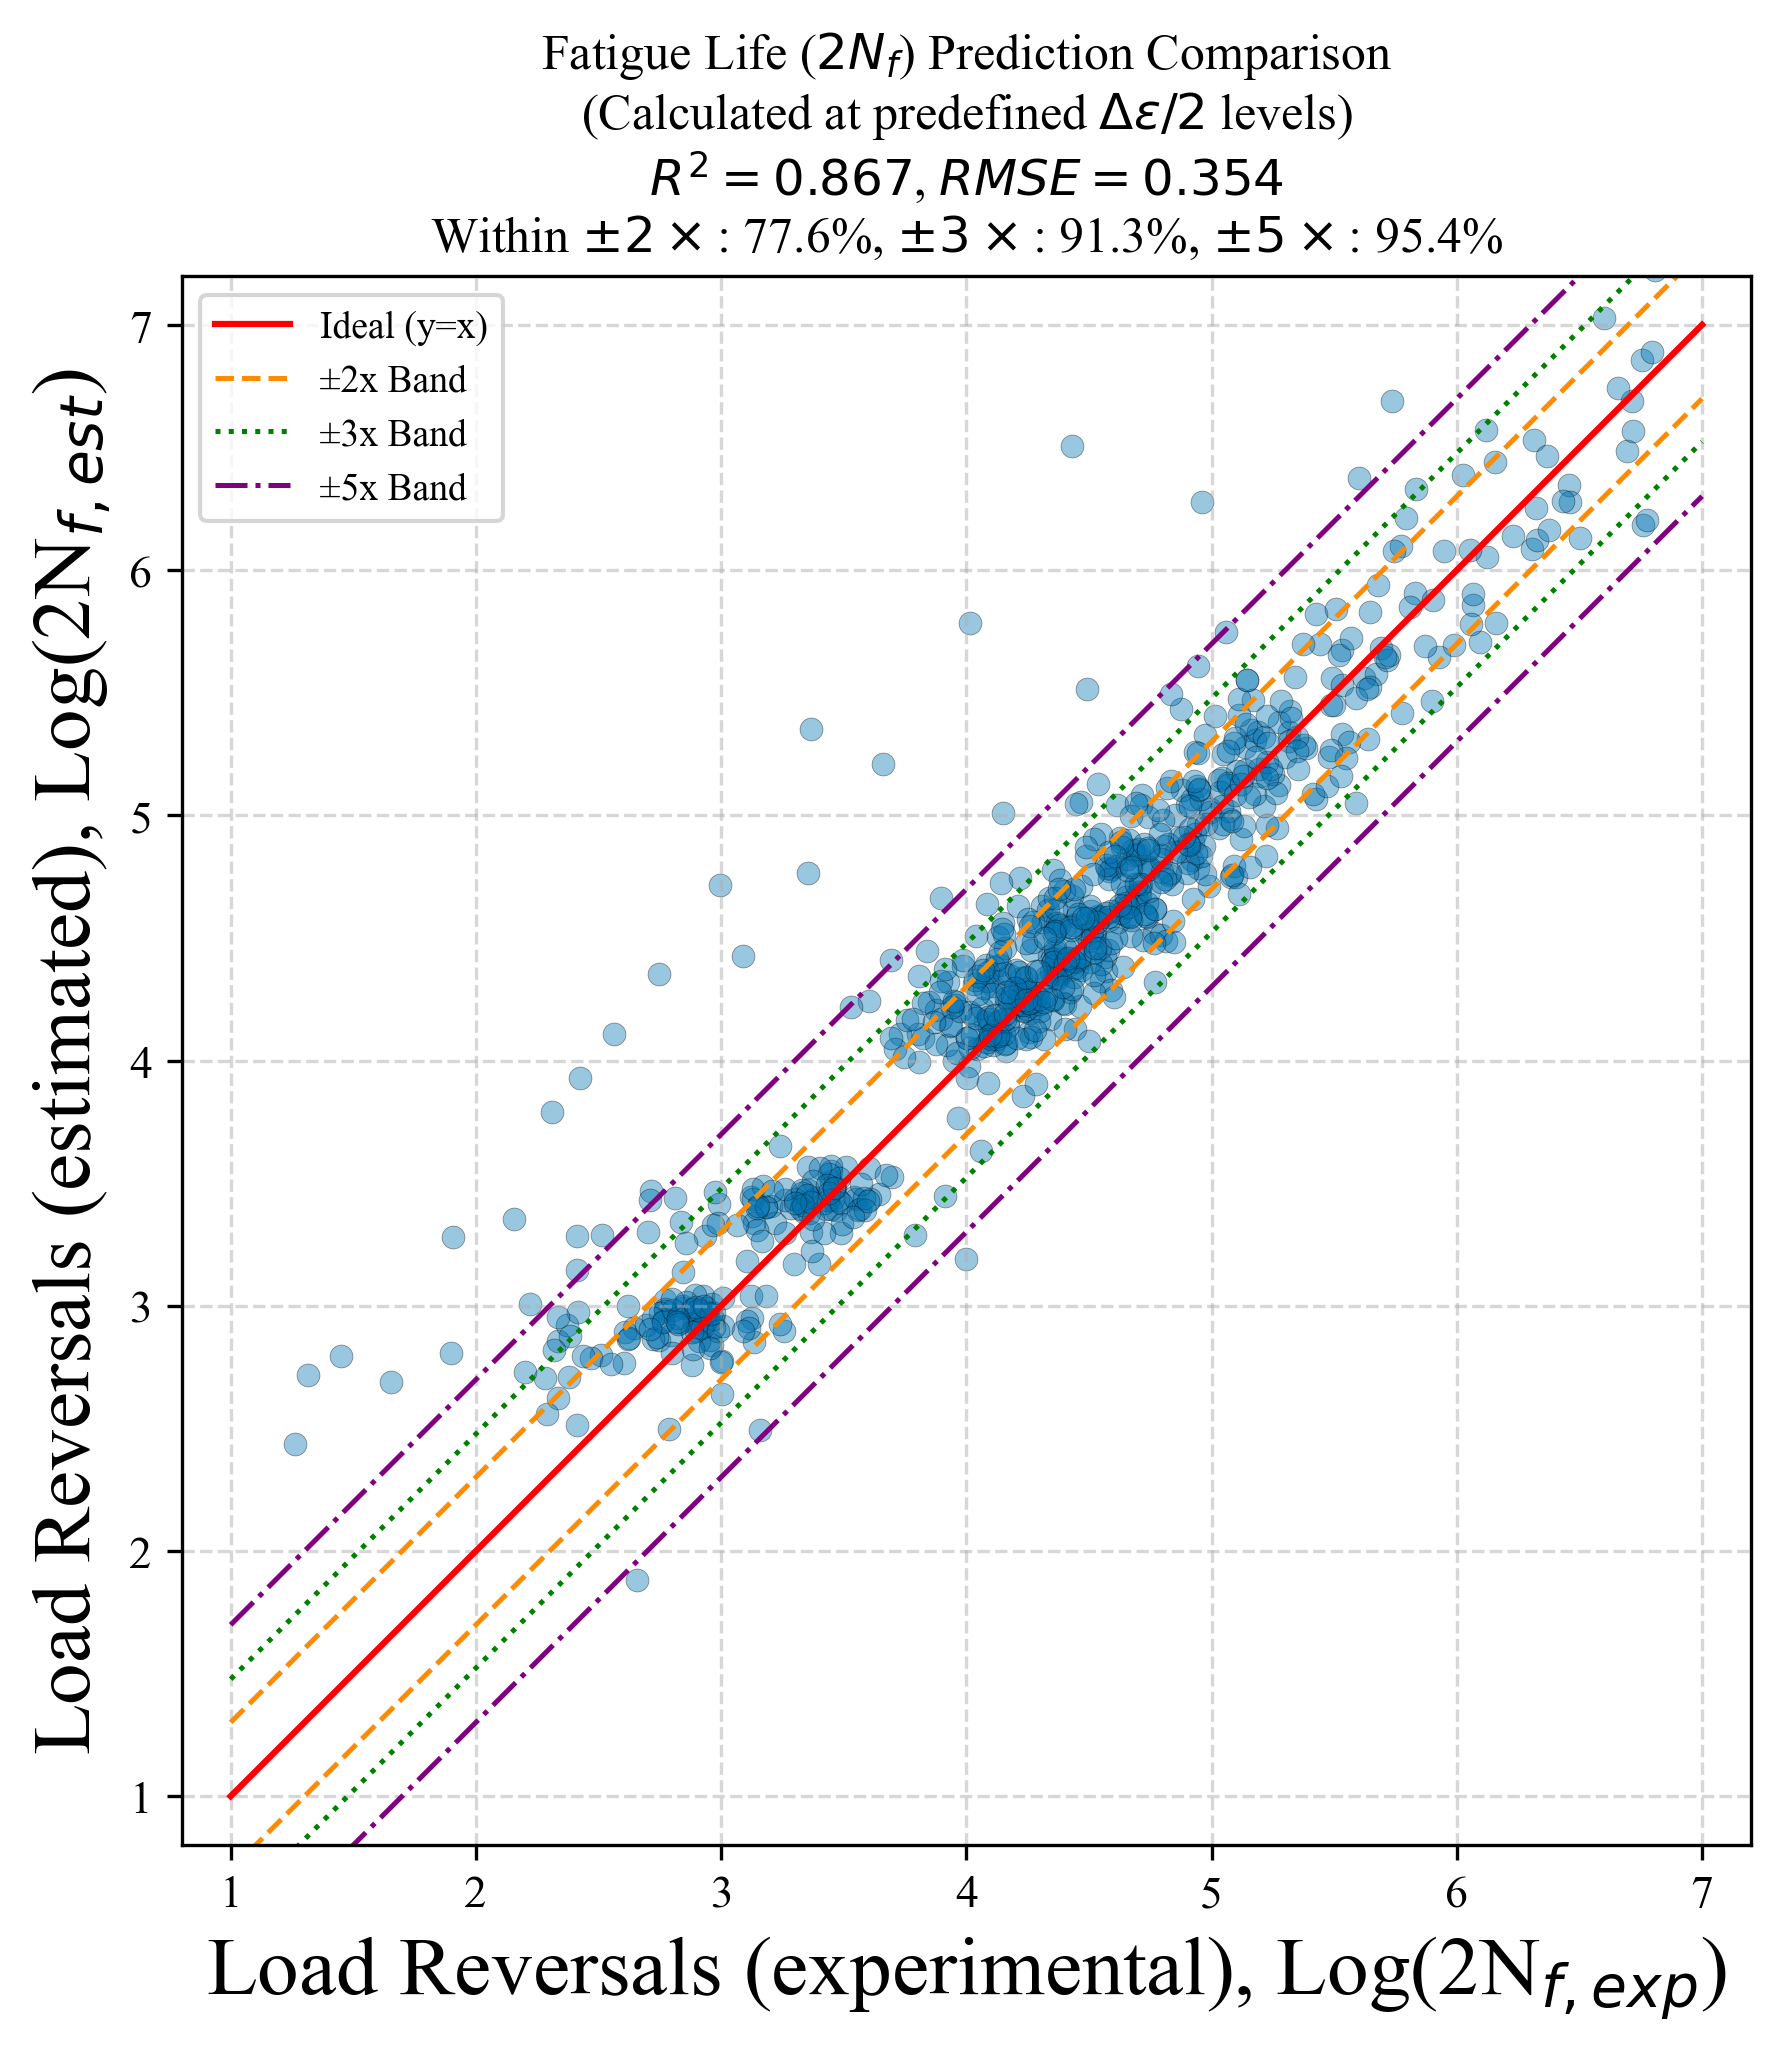

\nFatigue Life (log10(2Nf)) R2 Score: 0.8669
Fatigue Life (log10(2Nf)) RMSE: 0.3538
Percentage of predictions within ±1.3x scatter band: 41.42%
Percentage of predictions within ±2x scatter band: 77.59%
Percentage of predictions within ±3x scatter band: 91.35%
Percentage of predictions within ±5x scatter band: 95.41%


In [12]:
# Cell 4: 2Nf 계산 및 산점도 플로팅 (main0605.ipynb Cell 13 로직)
from sklearn.metrics import r2_score, mean_squared_error  # import 추가 (Cell 1이 실행되지 않은 경우를 대비)

if 'all_preds_orig_np' in locals() and 'all_targets_orig_np' in locals() and \
   'E_values_all_samples_np' in locals() and 'target_cols' in locals():

    predicted_params_all_samples = all_preds_orig_np
    true_params_all_samples = all_targets_orig_np
    
    try:
        # 인덱스는 solve_2Nf_from_strain 함수 내에서 target_cols를 기반으로 처리됨
        # 여기서는 별도로 spf_idx, b_idx 등을 정의할 필요 없음
        pass
    except ValueError as e:
        print(f"오류: target_cols 리스트에 필요한 파라미터 이름이 없습니다: {e}")
        raise

    # 각 샘플 및 각 변형률 진폭 레벨에 대해 2Nf_exp 및 2Nf_est 계산
    twoNf_exp_collected = []
    twoNf_est_collected = []
    
    num_test_samples = len(true_params_all_samples)
    print(f"\\nCalculating 2Nf_exp and 2Nf_est for {num_test_samples} test samples using {len(defined_total_strain_amplitudes)} strain levels...")

    for i in range(num_test_samples):
        params_true_sample = true_params_all_samples[i, :]
        params_pred_sample = predicted_params_all_samples[i, :]
        E_val_sample_i = E_values_all_samples_np[i]

        if any(np.isnan(params_true_sample)) or any(np.isnan(params_pred_sample)) or np.isnan(E_val_sample_i):
            # print(f"Skipping sample {i} due to NaN values: True_params={params_true_sample}, Pred_params={params_pred_sample}, E={E_val_sample_i}")
            continue
            
        for strain_amplitude_level in defined_total_strain_amplitudes:
            twoNf_exp = solve_2Nf_from_strain(params_true_sample, E_val_sample_i, strain_amplitude_level)
            twoNf_est = solve_2Nf_from_strain(params_pred_sample, E_val_sample_i, strain_amplitude_level)

            if not np.isnan(twoNf_exp) and not np.isnan(twoNf_est) and \
               twoNf_exp > 0 and twoNf_est > 0: # Ensure positive life values
                # Filter for a reasonable range of life, e.g., 10 to 10^7 cycles (2Nf)
                if 10**1 <= twoNf_exp <= 10**7 : #and 10**1 <= twoNf_est <= 10**7: (est 범위는 일단 제외)
                    twoNf_exp_collected.append(twoNf_exp)
                    twoNf_est_collected.append(twoNf_est)
                # else:
                    # print(f"Filtered out: exp={twoNf_exp:.1e}, est={twoNf_est:.1e} for strain {strain_amplitude_level}")
            # else:
                # print(f"NaN result: exp={twoNf_exp}, est={twoNf_est} for strain {strain_amplitude_level}")


    if not twoNf_exp_collected or not twoNf_est_collected:
        print("Error: No valid 2Nf data points collected. Check data or solve_2Nf_from_strain function.")
    else:
        log_2Nf_exp_final = np.log10(np.array(twoNf_exp_collected))
        log_2Nf_est_final = np.log10(np.array(twoNf_est_collected))
        print(f"Successfully calculated and filtered {len(log_2Nf_exp_final)} (2Nf_exp, 2Nf_est) pairs for plotting.")

        # 산점도 (Scatter Plot) 작성
        if len(log_2Nf_exp_final) > 1: # R2 score needs at least 2 points
            plt.figure(figsize=(8, 7), facecolor='none') # 배경 투명
            
            r2_2Nf_final = r2_score(log_2Nf_exp_final, log_2Nf_est_final)
            rmse_2Nf_final = np.sqrt(mean_squared_error(log_2Nf_exp_final, log_2Nf_est_final))
            
            # Scatter band inclusion rate 계산 (1.3x, 2x, 3x, 5x)
            # 원본 스케일에서 비율 계산 후 로그 변환된 값에 적용
            ratio_2Nf_final = np.array(twoNf_est_collected) / np.array(twoNf_exp_collected)
            
            inside_1_3x_2Nf_final = np.logical_and(ratio_2Nf_final >= 1/1.3, ratio_2Nf_final <= 1.3).mean() * 100
            inside_2x_2Nf_final = np.logical_and(ratio_2Nf_final >= 1/2, ratio_2Nf_final <= 2).mean() * 100
            inside_3x_2Nf_final = np.logical_and(ratio_2Nf_final >= 1/3, ratio_2Nf_final <= 3).mean() * 100
            inside_5x_2Nf_final = np.logical_and(ratio_2Nf_final >= 1/5, ratio_2Nf_final <= 5).mean() * 100
            
            plot_axis_min_log = 1.0 # min(log_2Nf_exp_final.min(), log_2Nf_est_final.min()) - 0.5
            plot_axis_max_log = 7.0 # max(log_2Nf_exp_final.max(), log_2Nf_est_final.max()) + 0.5
            line_vals_log = np.linspace(plot_axis_min_log, plot_axis_max_log, 100)

            scatter_color = palette[0] # Using the first color from the defined palette

            plt.scatter(log_2Nf_exp_final, log_2Nf_est_final, alpha=0.4, s=30, 
                        color=scatter_color, edgecolor='k', linewidth=0.2)
                        # label=f'$R^2 = {r2_2Nf_final:.3f}$') # R2는 제목이나 텍스트로 표시
            
            plt.plot(line_vals_log, line_vals_log, 'r-', linewidth=1.5, label='Ideal (y=x)')
            
            # Scatter band 플롯 (2x, 3x, 5x)
            log_factor_2 = np.log10(2.0)
            log_factor_3 = np.log10(3.0)
            log_factor_5 = np.log10(5.0)
            
            # 2x Band
            plt.plot(line_vals_log, line_vals_log + log_factor_2, color='darkorange', linestyle='--', linewidth=1.2, label='±2x Band')
            plt.plot(line_vals_log, line_vals_log - log_factor_2, color='darkorange', linestyle='--', linewidth=1.2)
            
            # 3x Band
            plt.plot(line_vals_log, line_vals_log + log_factor_3, color='green', linestyle=':', linewidth=1.2, label='±3x Band')
            plt.plot(line_vals_log, line_vals_log - log_factor_3, color='green', linestyle=':', linewidth=1.2)
            
            # 5x Band
            plt.plot(line_vals_log, line_vals_log + log_factor_5, color='purple', linestyle='-.', linewidth=1.2, label='±5x Band')
            plt.plot(line_vals_log, line_vals_log - log_factor_5, color='purple', linestyle='-.', linewidth=1.2)

            plt.xlabel('Load Reversals (experimental), Log(2N$_{f,exp}$)')
            plt.ylabel('Load Reversals (estimated), Log(2N$_{f,est}$)')
            
            title_text = (f'Fatigue Life ($2N_f$) Prediction Comparison\n'
                          f'(Calculated at predefined $\\Delta\\varepsilon/2$ levels)\n'
                          f'$R^2 = {r2_2Nf_final:.3f}$, $RMSE = {rmse_2Nf_final:.3f}$\n'
                          f'Within $\\pm 2\\times$: {inside_2x_2Nf_final:.1f}%, '
                          f'$\\pm 3\\times$: {inside_3x_2Nf_final:.1f}%, '
                          f'$\\pm 5\\times$: {inside_5x_2Nf_final:.1f}%')
            plt.title(title_text, fontsize=12) # 제목 폰트 크기 조정
            
            plt.xlim(plot_axis_min_log - 0.2, plot_axis_max_log + 0.2)
            plt.ylim(plot_axis_min_log - 0.2, plot_axis_max_log + 0.2)
            
            tick_values = np.arange(int(np.floor(plot_axis_min_log)), int(np.ceil(plot_axis_max_log)) + 1, 1.0)
            plt.xticks(tick_values)
            plt.yticks(tick_values)
            
            plt.legend(frameon=True, loc='upper left', fontsize=9)
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.gca().set_aspect('equal', adjustable='box')
            plt.gca().set_facecolor('none') # 그래프 배경 투명

            plt.tight_layout()
            #plt.savefig("FatigueLife_2Nf_comparison_standalone.pdf", bbox_inches='tight', transparent=True)
            plt.show()
            
            print(f"\\nFatigue Life (log10(2Nf)) R2 Score: {r2_2Nf_final:.4f}")
            print(f"Fatigue Life (log10(2Nf)) RMSE: {rmse_2Nf_final:.4f}")
            print(f"Percentage of predictions within ±1.3x scatter band: {inside_1_3x_2Nf_final:.2f}%")
            print(f"Percentage of predictions within ±2x scatter band: {inside_2x_2Nf_final:.2f}%")
            print(f"Percentage of predictions within ±3x scatter band: {inside_3x_2Nf_final:.2f}%")
            print(f"Percentage of predictions within ±5x scatter band: {inside_5x_2Nf_final:.2f}%")

        else:
            print("No valid 2Nf data points (or less than 2) to plot after all calculations and filtering.")
else:
    print("\\n필수 변수가 정의되지 않아 피로 수명(2Nf) 비교 평가를 건너뜁니다. 데이터 로딩 셀을 확인하세요.")


In [13]:
# Cell 11: 단조 물성치 예측 R²이 피로 수명 변동성에 미치는 영향 분석
import torch
import torch.nn as nn

# --- FatiguePINN 클래스 정의 (FatiguePredictor0605.py와 동일) ---
class FatiguePINN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[128, 256, 128], dropout_p=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout_p = dropout_p 

        layers = []
        last_dim = input_dim
        for i, hidden_dim in enumerate(hidden_dims):
            layers.append(nn.Linear(last_dim, hidden_dim))
            layers.append(nn.ReLU())
            if self.dropout_p > 0:
                layers.append(nn.Dropout(p=self.dropout_p))
            last_dim = hidden_dim
        
        layers.append(nn.Linear(last_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# --- inverse_transform_targets 함수 정의 ---
def inverse_transform_targets(y_scaled_data, scalers_y_dict, target_cols_list):
    if y_scaled_data.ndim == 1:
        y_scaled_data = y_scaled_data.reshape(1, -1)
        
    y_transformed_individually = np.zeros_like(y_scaled_data)
    for i, col_name in enumerate(target_cols_list):
        if col_name not in scalers_y_dict: 
            raise KeyError(f"Scaler for target '{col_name}' not found in scalers_y_dict.")
        y_transformed_individually[:, i] = scalers_y_dict[col_name].inverse_transform(y_scaled_data[:, i].reshape(-1, 1)).flatten()
    
    y_orig_scale = y_transformed_individually.copy()
    
    # epf에 대한 expm1 변환 적용
    if 'epf' in target_cols_list:
        epf_idx = target_cols_list.index('epf')
        y_orig_scale[:, epf_idx] = np.expm1(y_transformed_individually[:, epf_idx])
    
    if y_scaled_data.shape[0] == 1 and y_orig_scale.shape[0] == 1:
         return y_orig_scale.flatten()
    return y_orig_scale

# --- AI 모델 및 스케일러 로드 ---
def load_model_and_scalers():
    device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
    
    # 모델 구조 설정 (FatiguePredictor0605.py와 동일)
    model_hidden_dims = [192, 384, 352, 224]
    model_dropout_p = 0.35
    input_dim = 4 
    output_dim = 4 

    model = FatiguePINN(input_dim=input_dim, output_dim=output_dim, 
                        hidden_dims=model_hidden_dims, dropout_p=model_dropout_p)
    
    try:
        # 모델 로드
        map_location = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
        model.load_state_dict(torch.load('best_fatigue_pinn_model.pth', map_location=map_location))
        model.to(device)
        model.eval()
        
        # 스케일러 로드
        scaler_X = joblib.load('scaler_X.pkl')
        data_y = joblib.load('scalers_y.pkl')
        
        if isinstance(data_y, dict) and 'scalers' in data_y and 'target_cols' in data_y:
            scalers_y_dict = data_y['scalers']
            target_cols_list = data_y['target_cols']
        else:
            raise ValueError("Unexpected format in scalers_y.pkl file.")
            
        print(f"AI model and scalers loaded successfully. Device: {device}")
        return model, scaler_X, scalers_y_dict, target_cols_list, device
    
    except FileNotFoundError as e:
        print(f"File not found: {e}")
        return None, None, None, None, None
    except Exception as e:
        print(f"Error loading model/scalers: {e}")
        return None, None, None, None, None

# --- 개선된 조성-물성치 변환 모듈 사용 ---
import composition_to_properties as ctp

# --- 피로 파라미터 예측 함수 ---
def predict_fatigue_params_from_monotonic(E_gpa, YS_mpa, TS_mpa, HB,
                                          ai_model, scaler_X_loaded,
                                          scalers_y_dict_loaded, target_cols_list_loaded,
                                          device_loaded):
    # HB 처리
    hb_processed = HB
    if HB is None or np.isnan(HB) or HB <= 0:
        if TS_mpa is not None and not np.isnan(TS_mpa) and TS_mpa > 0:
            hb_processed = 1.8 * TS_mpa + 105
        else:
            return None

    E_mpa = E_gpa * 1000
    features_np = np.array([[E_mpa, YS_mpa, TS_mpa, hb_processed]], dtype=np.float32)
    
    try:
        scaled_features_np = scaler_X_loaded.transform(features_np)
        scaled_features = torch.tensor(scaled_features_np, dtype=torch.float32).to(device_loaded)

        with torch.no_grad():
            predicted_params_scaled = ai_model(scaled_features)

        predicted_params_orig = inverse_transform_targets(
            predicted_params_scaled.cpu().numpy(),
            scalers_y_dict_loaded,
            target_cols_list_loaded
        )
        
        params_dict = dict(zip(target_cols_list_loaded, predicted_params_orig))
        
        return [params_dict.get('spf_MPa'), params_dict.get('b'),
                params_dict.get('epf'), params_dict.get('c')]
    except Exception as e:
        print(f"Error predicting fatigue parameters: {e}")
        return None

# --- R²에 따른 오차율 설정 함수 ---
def get_error_percentage_from_r2(r_squared):
    if r_squared >= 0.9: return 5    # R² >= 0.9 -> ±5% error
    if r_squared >= 0.7: return 10   # R² 0.7~0.9 -> ±10% error
    if r_squared >= 0.5: return 20   # R² 0.5~0.7 -> ±20% error
    if r_squared >= 0.3: return 30   # R² 0.3~0.5 -> ±30% error
    return 40                        # R² < 0.3 -> ±40% error

print("Monotonic property prediction R-squared impact analysis module loaded successfully.")


Monotonic property prediction R-squared impact analysis module loaded successfully.


In [15]:
# Cell 12: 단조 물성치 예측 R² 영향 시뮬레이션 실행
pd = pd if 'pd' in locals() else __import__('pandas')

# --- 시뮬레이션 설정 ---
# 1. 기준(Nominal) 조성 및 물성치 설정
SAMPLE_COMPOSITION = {
    'C': 0.25, 'Mn': 0.8, 'Si': 0.3, 'Cr': 0.5, 'Mo': 0.1, 
    'P': 0.015, 'S': 0.015, 'Ni': 0.0, 'V': 0.0, 'Nb': 0.0, 
    'Ti': 0.0, 'Al': 0.0, 'N': 0.0, 'Cu': 0.0, 'B': 0.0
}

# 개선된 조성-물성치 모델로 기준 물성치 계산
nominal_props = ctp.calculate_monotonic_properties(SAMPLE_COMPOSITION)
NOMINAL_E_GPA = nominal_props.get('E_gpa', 200.0)
NOMINAL_YS_MPA = nominal_props.get('YS_mpa', 500.0)
NOMINAL_TS_MPA = nominal_props.get('TS_mpa', 700.0)
NOMINAL_HB = nominal_props.get('HB', 200.0)
POISSON_RATIO = 0.3

print(f"Reference composition: {SAMPLE_COMPOSITION}")
print(f"Reference monotonic properties:")
print(f"  E: {NOMINAL_E_GPA:.1f} GPa")
print(f"  YS: {NOMINAL_YS_MPA:.1f} MPa") 
print(f"  TS: {NOMINAL_TS_MPA:.1f} MPa")
print(f"  HB: {NOMINAL_HB:.1f}")

# 2. 시뮬레이션 파라미터
R_SQUARED_LEVELS_TO_TEST = [0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.99]
N_SAMPLES_PER_R2 = 100  # 각 R² 레벨당 샘플 수
TARGET_STRAIN_AMPLITUDE = 0.005  # 분석할 변형률 진폭

# 3. AI 모델 및 스케일러 로드
model, scaler_X, scalers_y_dict, target_cols_list, device = load_model_and_scalers()

if model is None:
    print("ERROR: Cannot load AI model. Simulation cannot proceed.")
    print("Please ensure the following files exist in the current directory:")
    print("  - best_fatigue_pinn_model.pth")
    print("  - scaler_X.pkl") 
    print("  - scalers_y.pkl")
else:
    print("AI model loaded successfully.")
    print(f"Target columns: {target_cols_list}")
    
    # --- 시뮬레이션 실행 ---
    all_results = []
    np.random.seed(42)  # 재현 가능한 결과를 위한 시드 설정
    
    for r2_value in R_SQUARED_LEVELS_TO_TEST:
        error_percent = get_error_percentage_from_r2(r2_value)
        print(f"\nSimulating R² = {r2_value:.2f} (Monotonic property error: ±{error_percent}%)")
        
        current_2Nf_values_for_r2 = []
        valid_predictions = 0
        
        for sample_idx in range(N_SAMPLES_PER_R2):
            # 각 물성치에 오차 적용 (독립적으로)
            perturbed_E_gpa = NOMINAL_E_GPA * (1 + np.random.uniform(-error_percent, error_percent) / 100.0)
            perturbed_YS_mpa = NOMINAL_YS_MPA * (1 + np.random.uniform(-error_percent, error_percent) / 100.0)
            perturbed_TS_mpa = NOMINAL_TS_MPA * (1 + np.random.uniform(-error_percent, error_percent) / 100.0)
            perturbed_HB = NOMINAL_HB * (1 + np.random.uniform(-error_percent, error_percent) / 100.0)
            
            # 물리적 제약 조건: YS ≤ TS 유지
            if perturbed_YS_mpa > perturbed_TS_mpa:
                perturbed_YS_mpa = perturbed_TS_mpa * np.random.uniform(0.85, 0.98)
            
            # 음수 값 방지
            perturbed_E_gpa = max(perturbed_E_gpa, 50.0)
            perturbed_YS_mpa = max(perturbed_YS_mpa, 100.0)
            perturbed_TS_mpa = max(perturbed_TS_mpa, 200.0)
            perturbed_HB = max(perturbed_HB, 50.0)
            
            # AI 모델로 피로 파라미터 예측
            fatigue_params_predicted = predict_fatigue_params_from_monotonic(
                perturbed_E_gpa, perturbed_YS_mpa, perturbed_TS_mpa, perturbed_HB,
                model, scaler_X, scalers_y_dict, target_cols_list, device
            )
            
            if fatigue_params_predicted and not any(p is None or np.isnan(p) for p in fatigue_params_predicted):
                # solve_2Nf_from_strain 함수 사용 (Cell 3에서 정의됨)
                two_Nf = solve_2Nf_from_strain(
                    fatigue_params_predicted,
                    perturbed_E_gpa * 1000,  # E는 MPa로 전달
                    TARGET_STRAIN_AMPLITUDE
                )
                
                if not np.isnan(two_Nf) and 1e2 <= two_Nf <= 1e7:  # 유효 범위 필터링
                    current_2Nf_values_for_r2.append(two_Nf)
                    valid_predictions += 1
        
        if current_2Nf_values_for_r2:
            log10_2Nf_values = np.log10(np.array(current_2Nf_values_for_r2))
            all_results.append({
                'r_squared': r2_value,
                'error_percent_monotonic': error_percent,
                'log10_2Nf_values': log10_2Nf_values,
                'mean_log10_2Nf': np.mean(log10_2Nf_values),
                'std_log10_2Nf': np.std(log10_2Nf_values),
                'valid_samples': len(current_2Nf_values_for_r2)
            })
            print(f"  Valid predictions: {valid_predictions}/{N_SAMPLES_PER_R2} (Mean log₁₀(2Nf): {np.mean(log10_2Nf_values):.2f} ± {np.std(log10_2Nf_values):.2f})")
        else:
            print(f"  No valid 2Nf values obtained.")
    
    print(f"\nSimulation completed. Results generated for {len(all_results)} R² levels.")


Reference composition: {'C': 0.25, 'Mn': 0.8, 'Si': 0.3, 'Cr': 0.5, 'Mo': 0.1, 'P': 0.015, 'S': 0.015, 'Ni': 0.0, 'V': 0.0, 'Nb': 0.0, 'Ti': 0.0, 'Al': 0.0, 'N': 0.0, 'Cu': 0.0, 'B': 0.0}
Reference monotonic properties:
  E: 205.1 GPa
  YS: 1203.6 MPa
  TS: 1265.3 MPa
  HB: 538.8
AI model and scalers loaded successfully. Device: mps
AI model loaded successfully.
Target columns: ['spf_MPa', 'b', 'epf', 'c']

Simulating R² = 0.20 (Monotonic property error: ±40%)
  Valid predictions: 100/100 (Mean log₁₀(2Nf): 4.48 ± 0.50)

Simulating R² = 0.30 (Monotonic property error: ±30%)
  Valid predictions: 100/100 (Mean log₁₀(2Nf): 4.40 ± 0.34)

Simulating R² = 0.40 (Monotonic property error: ±30%)
  Valid predictions: 100/100 (Mean log₁₀(2Nf): 4.36 ± 0.35)

Simulating R² = 0.50 (Monotonic property error: ±20%)
  Valid predictions: 100/100 (Mean log₁₀(2Nf): 4.34 ± 0.14)

Simulating R² = 0.60 (Monotonic property error: ±20%)
  Valid predictions: 100/100 (Mean log₁₀(2Nf): 4.34 ± 0.15)

Simulating R² 

Simulation Results Summary:
  R² Error (%)  Valid Samples Mean log₁₀(2Nf) Std Dev CV (%)
0.20       ±40            100           4.485   0.505   11.3
0.30       ±30            100           4.398   0.342    7.8
0.40       ±30            100           4.361   0.350    8.0
0.50       ±20            100           4.343   0.144    3.3
0.60       ±20            100           4.340   0.151    3.5
0.70       ±10            100           4.334   0.040    0.9
0.80       ±10            100           4.329   0.044    1.0
0.90        ±5            100           4.328   0.020    0.5
0.99        ±5            100           4.325   0.020    0.5


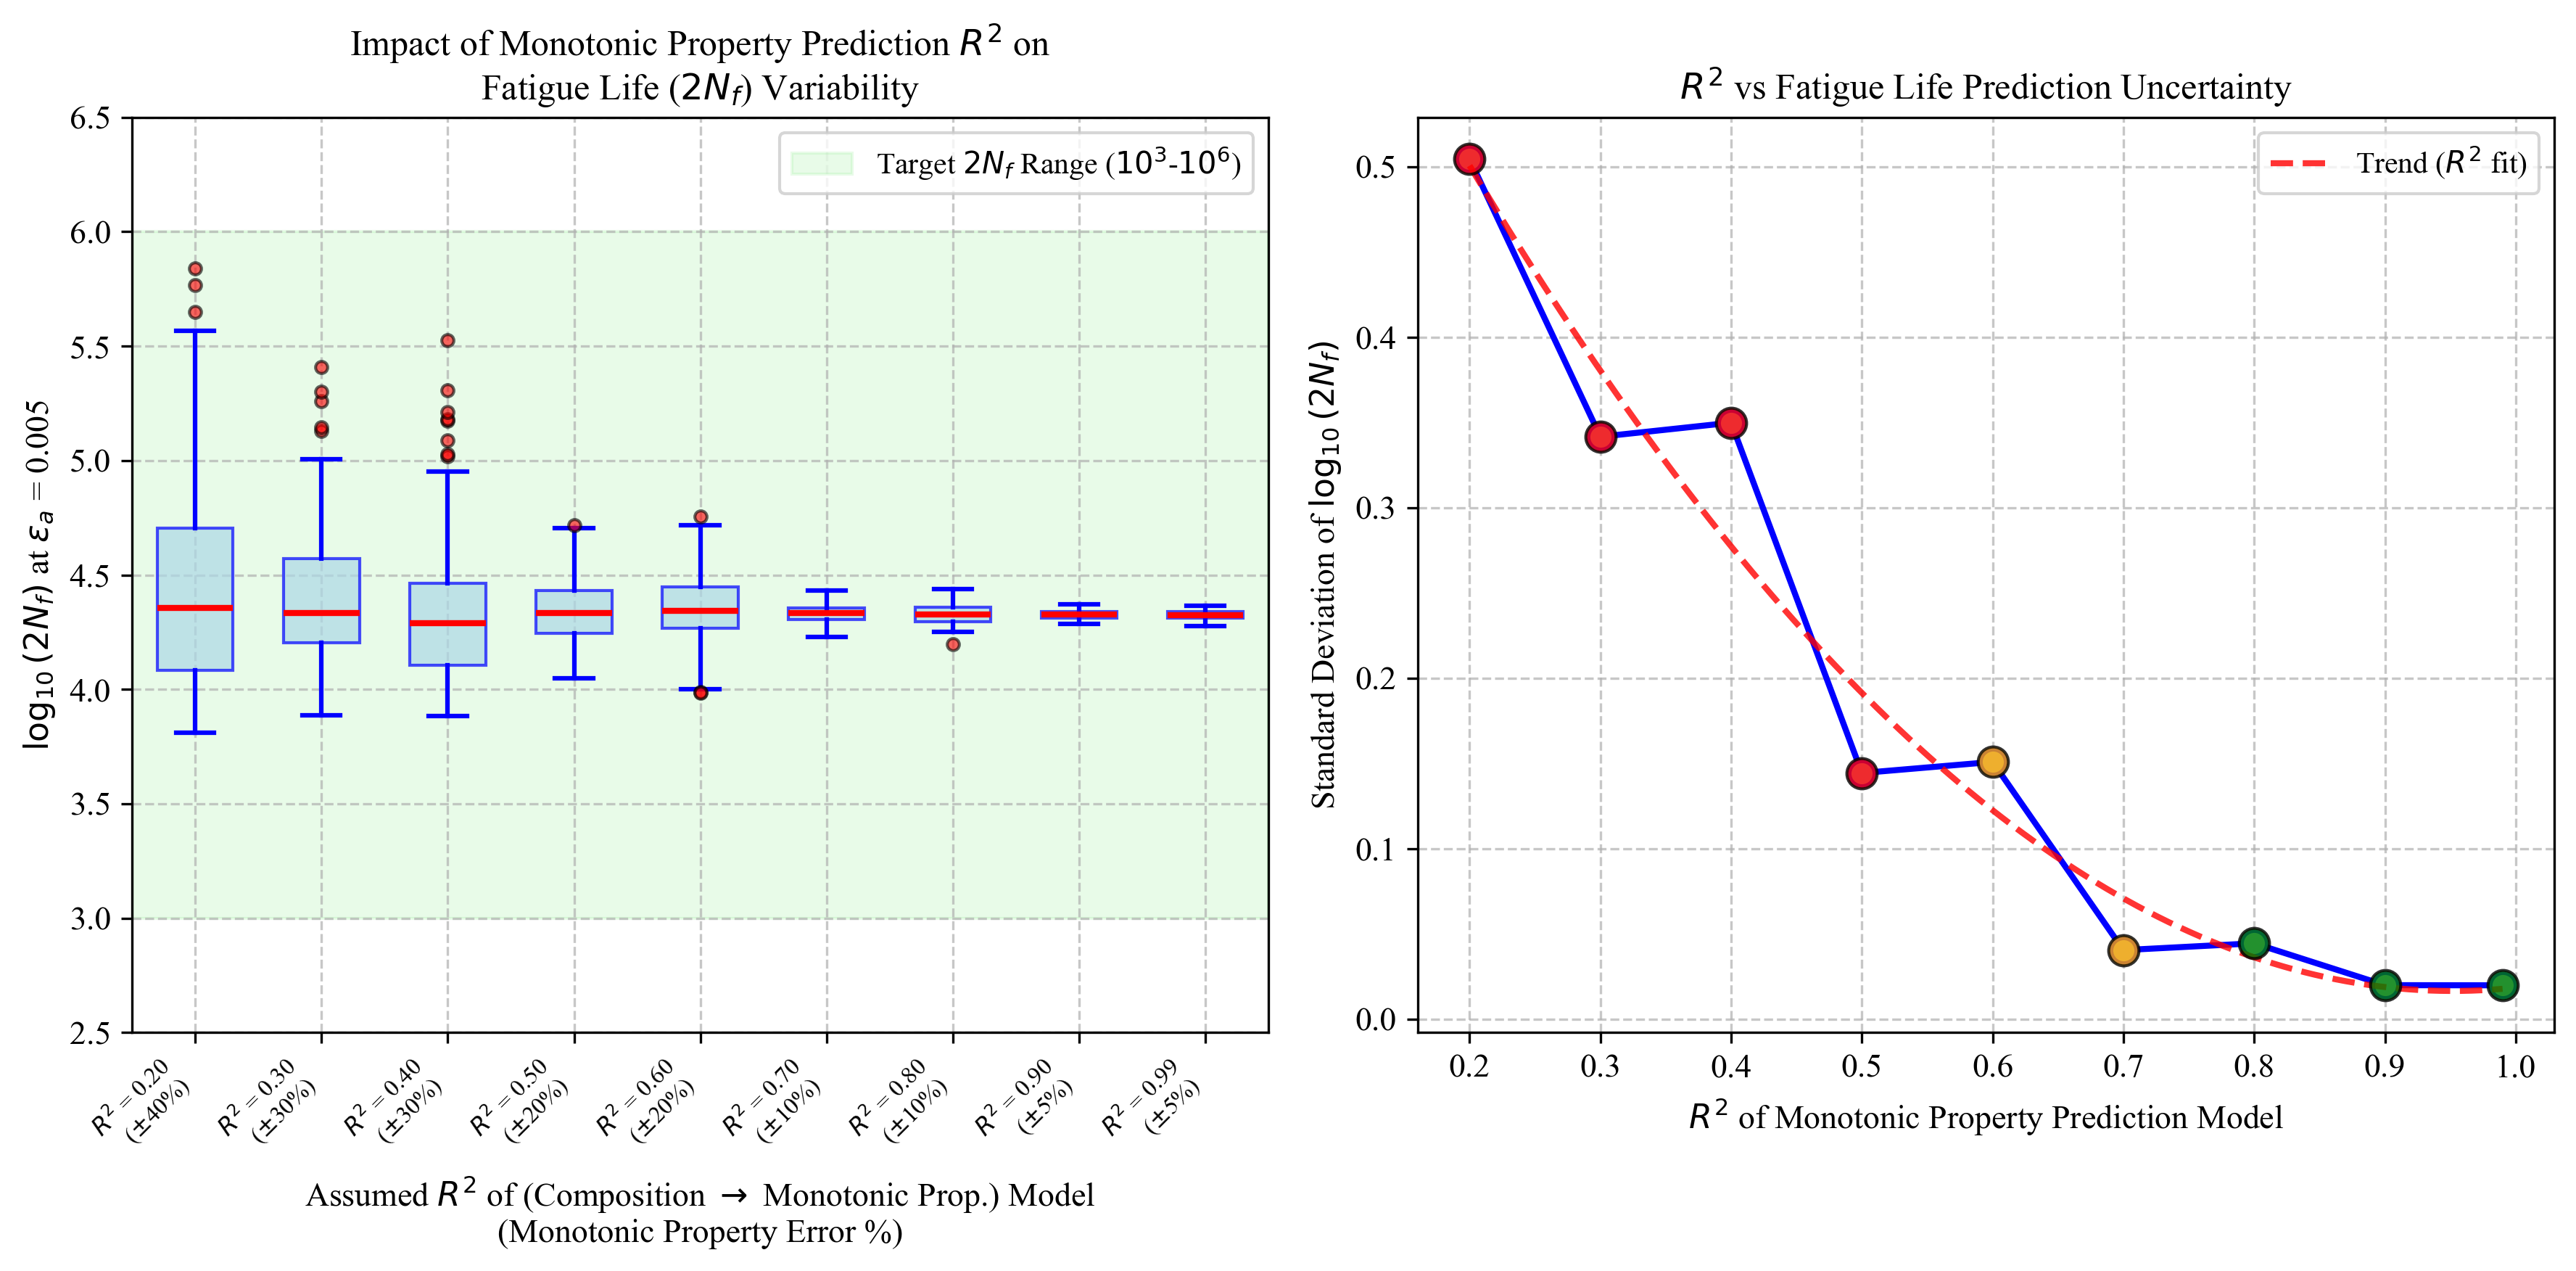


Key Analysis Results:
1. Highest R² (0.99): Standard deviation = 0.020
2. Lowest R² (0.20): Standard deviation = 0.505
3. Uncertainty increase ratio: 25.5×
4. 95% confidence interval range (±2σ):
   - Highest R²: ±0.04 log₁₀(2Nf) ≈ 1.1× variation
   - Lowest R²: ±1.01 log₁₀(2Nf) ≈ 10.2× variation


In [16]:
# Cell 13: 결과 시각화 및 분석
if 'all_results' in locals() and all_results:
    # --- 결과 요약 테이블 생성 ---
    summary_data = []
    for result in all_results:
        summary_data.append({
            'R²': result['r_squared'],
            'Error (%)': f"±{result['error_percent_monotonic']}",
            'Valid Samples': result['valid_samples'],
            'Mean log₁₀(2Nf)': f"{result['mean_log10_2Nf']:.3f}",
            'Std Dev': f"{result['std_log10_2Nf']:.3f}",
            'CV (%)': f"{(result['std_log10_2Nf']/result['mean_log10_2Nf']*100):.1f}"
        })
    
    summary_df = pd.DataFrame(summary_data)
    print("Simulation Results Summary:")
    print(summary_df.to_string(index=False))
    
    # --- 박스플롯 시각화 ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # 서브플롯 1: 박스플롯
    plot_data = [result['log10_2Nf_values'] for result in all_results if len(result['log10_2Nf_values']) > 0]
    valid_r2_values = [result['r_squared'] for result in all_results if len(result['log10_2Nf_values']) > 0]
    valid_error_percents = [result['error_percent_monotonic'] for result in all_results if len(result['log10_2Nf_values']) > 0]
    
    positions = np.arange(len(plot_data))
    
    if plot_data:
        box_plot = ax1.boxplot(plot_data, positions=positions, widths=0.6, patch_artist=True,
                              medianprops={'color': 'red', 'linewidth': 2},
                              boxprops={'facecolor': 'lightblue', 'edgecolor': 'blue', 'alpha': 0.7},
                              whiskerprops={'color': 'blue', 'linewidth': 1.5},
                              capprops={'color': 'blue', 'linewidth': 1.5},
                              flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 4, 'alpha': 0.6})
        
        # X축 레이블 설정
        x_labels = [f"$R^2$ = {r2:.2f}\n($\\pm${err}%)" for r2, err in zip(valid_r2_values, valid_error_percents)]
        ax1.set_xticks(positions)
        ax1.set_xticklabels(x_labels, fontsize=8, rotation=45, ha='right')
        ax1.set_xlabel('Assumed $R^2$ of (Composition $\\rightarrow$ Monotonic Prop.) Model\n(Monotonic Property Error %)', fontsize=11)
        ax1.set_ylabel(f'$\\log_{{10}}(2N_f)$ at $\\varepsilon_a$ = {TARGET_STRAIN_AMPLITUDE}', fontsize=11)
        ax1.set_title('Impact of Monotonic Property Prediction $R^2$ on\nFatigue Life ($2N_f$) Variability', fontsize=12)
        ax1.grid(True, linestyle='--', alpha=0.7)
        
        # 2Nf = 10³ ~ 10⁶ 범위 강조
        ax1.axhspan(3, 6, color='lightgreen', alpha=0.2, label='Target $2N_f$ Range ($10^3$-$10^6$)')
        ax1.set_ylim(2.5, 6.5)
        ax1.legend(loc='upper right', fontsize=10)
        
        # 서브플롯 2: 표준편차 vs R² 관계
        std_values = [result['std_log10_2Nf'] for result in all_results if len(result['log10_2Nf_values']) > 0]
        
        ax2.plot(valid_r2_values, std_values, 'bo-', linewidth=2, markersize=8, markerfacecolor='lightblue')
        ax2.set_xlabel('$R^2$ of Monotonic Property Prediction Model', fontsize=11)
        ax2.set_ylabel('Standard Deviation of $\\log_{10}(2N_f)$', fontsize=11)
        ax2.set_title('$R^2$ vs Fatigue Life Prediction Uncertainty', fontsize=12)
        ax2.grid(True, linestyle='--', alpha=0.7)
        
        # 추세선 추가
        z = np.polyfit(valid_r2_values, std_values, 2)  # 2차 다항식 피팅
        p = np.poly1d(z)
        x_smooth = np.linspace(min(valid_r2_values), max(valid_r2_values), 100)
        ax2.plot(x_smooth, p(x_smooth), 'r--', alpha=0.8, linewidth=2, label='Trend ($R^2$ fit)')
        ax2.legend(fontsize=10)
        
        # R² 범위별 색상 구분
        for i, (r2, std_val) in enumerate(zip(valid_r2_values, std_values)):
            if r2 >= 0.8:
                color = 'green'
            elif r2 >= 0.6:
                color = 'orange'
            else:
                color = 'red'
            ax2.scatter(r2, std_val, c=color, s=100, alpha=0.8, edgecolors='black', zorder=5)
    
    plt.tight_layout()
    plt.show()
    
    # --- 주요 인사이트 출력 ---
    if len(all_results) >= 2:
        best_r2_result = max(all_results, key=lambda x: x['r_squared'])
        worst_r2_result = min(all_results, key=lambda x: x['r_squared'])
        
        print(f"\nKey Analysis Results:")
        print(f"1. Highest R² ({best_r2_result['r_squared']:.2f}): Standard deviation = {best_r2_result['std_log10_2Nf']:.3f}")
        print(f"2. Lowest R² ({worst_r2_result['r_squared']:.2f}): Standard deviation = {worst_r2_result['std_log10_2Nf']:.3f}")
        
        uncertainty_ratio = worst_r2_result['std_log10_2Nf'] / best_r2_result['std_log10_2Nf']
        print(f"3. Uncertainty increase ratio: {uncertainty_ratio:.1f}×")
        
        # 2Nf 범위 계산 (±2σ 기준)
        best_2sigma_range = 2 * best_r2_result['std_log10_2Nf']
        worst_2sigma_range = 2 * worst_r2_result['std_log10_2Nf']
        
        print(f"4. 95% confidence interval range (±2σ):")
        print(f"   - Highest R²: ±{best_2sigma_range:.2f} log₁₀(2Nf) ≈ {10**best_2sigma_range:.1f}× variation")
        print(f"   - Lowest R²: ±{worst_2sigma_range:.2f} log₁₀(2Nf) ≈ {10**worst_2sigma_range:.1f}× variation")
    
    # --- 결과 데이터 저장 옵션 ---
    if len(all_results) > 0:
        # 모든 결과를 하나의 DataFrame으로 통합
        all_data_for_export = []
        for result in all_results:
            for log_2nf in result['log10_2Nf_values']:
                all_data_for_export.append({
                    'R_squared': result['r_squared'],
                    'Error_percent': result['error_percent_monotonic'],
                    'Log10_2Nf': log_2nf,
                    'Target_strain_amplitude': TARGET_STRAIN_AMPLITUDE
                })
        
        export_df = pd.DataFrame(all_data_for_export)
        
       
else:
    print("ERROR: No simulation results available for visualization.")
    print("Please run Cell 6 first to complete the simulation.")


In [17]:
# Cell 21: TS 데이터 그룹별 분석 및 시각화
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 파일 로드
try:
    df = pd.read_excel('TrainSet0507_Composition.xlsx')
    print(f"데이터 로드 완료: {df.shape[0]}개 행, {df.shape[1]}개 열")
    print(f"TS 열 통계:")
    print(df['TS'].describe())
    
    # TS 열에서 결측값 확인 및 제거
    df_clean = df.dropna(subset=['TS'])
    print(f"\n결측값 제거 후: {df_clean.shape[0]}개 행")
    
    # TS 데이터를 3개 그룹으로 분류
    def classify_ts_group(ts_value):
        if ts_value < 700:
            return 'Group 1: TS < 700'
        elif 700 <= ts_value < 1000:
            return 'Group 2: 700 ≤ TS < 1000'
        else:
            return 'Group 3: TS ≥ 1000'
    
    df_clean['TS_Group'] = df_clean['TS'].apply(classify_ts_group)
    
    # 그룹별 데이터 개수 확인
    group_counts = df_clean['TS_Group'].value_counts()
    print(f"\n그룹별 데이터 개수:")
    for group, count in group_counts.items():
        print(f"  {group}: {count}개")
    
    # 시각화
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. 히스토그램 - 전체 TS 분포
    axes[0, 0].hist(df_clean['TS'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].axvline(x=700, color='red', linestyle='--', linewidth=2, label='TS = 700')
    axes[0, 0].axvline(x=1000, color='red', linestyle='--', linewidth=2, label='TS = 1000')
    axes[0, 0].set_xlabel('Tensile Strength (TS) [MPa]')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Overall Distribution of TS Values')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. 박스플롯 - 그룹별 TS 분포
    group_data = [df_clean[df_clean['TS_Group'] == group]['TS'].values 
                  for group in ['Group 1: TS < 700', 'Group 2: 700 ≤ TS < 1000', 'Group 3: TS ≥ 1000']]
    group_labels = ['Group 1\n(TS < 700)', 'Group 2\n(700 ≤ TS < 1000)', 'Group 3\n(TS ≥ 1000)']
    
    bp = axes[0, 1].boxplot(group_data, labels=group_labels, patch_artist=True)
    colors = ['lightcoral', 'lightgreen', 'lightblue']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    axes[0, 1].set_ylabel('Tensile Strength (TS) [MPa]')
    axes[0, 1].set_title('TS Distribution by Groups')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. 파이 차트 - 그룹별 비율
    group_counts_ordered = [
        len(df_clean[df_clean['TS_Group'] == 'Group 1: TS < 700']),
        len(df_clean[df_clean['TS_Group'] == 'Group 2: 700 ≤ TS < 1000']),
        len(df_clean[df_clean['TS_Group'] == 'Group 3: TS ≥ 1000'])
    ]
    
    axes[1, 0].pie(group_counts_ordered, labels=group_labels, colors=colors, autopct='%1.1f%%', startangle=90)
    axes[1, 0].set_title('Distribution of Samples by TS Groups')
    
    # 4. 바 차트 - 그룹별 통계
    group_stats = []
    for i, group_name in enumerate(['Group 1: TS < 700', 'Group 2: 700 ≤ TS < 1000', 'Group 3: TS ≥ 1000']):
        group_data_stats = df_clean[df_clean['TS_Group'] == group_name]['TS']
        group_stats.append({
            'Group': f'Group {i+1}',
            'Count': len(group_data_stats),
            'Mean': group_data_stats.mean(),
            'Std': group_data_stats.std(),
            'Min': group_data_stats.min(),
            'Max': group_data_stats.max()
        })
    
    stats_df = pd.DataFrame(group_stats)
    x_pos = np.arange(len(stats_df))
    
    axes[1, 1].bar(x_pos, stats_df['Count'], color=colors, alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('Groups')
    axes[1, 1].set_ylabel('Number of Samples')
    axes[1, 1].set_title('Sample Count by TS Groups')
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels(stats_df['Group'])
    axes[1, 1].grid(True, alpha=0.3)
    
    # 각 바 위에 개수 표시
    for i, count in enumerate(stats_df['Count']):
        axes[1, 1].text(i, count + max(stats_df['Count'])*0.01, str(count), 
                        ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 그룹별 상세 통계 출력
    print(f"\n=== 그룹별 상세 통계 ===")
    for i, group_name in enumerate(['Group 1: TS < 700', 'Group 2: 700 ≤ TS < 1000', 'Group 3: TS ≥ 1000']):
        group_data_detailed = df_clean[df_clean['TS_Group'] == group_name]['TS']
        print(f"\n{group_name}:")
        print(f"  샘플 수: {len(group_data_detailed)}개")
        print(f"  평균: {group_data_detailed.mean():.1f} MPa")
        print(f"  표준편차: {group_data_detailed.std():.1f} MPa")
        print(f"  최솟값: {group_data_detailed.min():.1f} MPa")
        print(f"  최댓값: {group_data_detailed.max():.1f} MPa")
        print(f"  25% 분위수: {group_data_detailed.quantile(0.25):.1f} MPa")
        print(f"  50% 분위수(중앙값): {group_data_detailed.quantile(0.50):.1f} MPa")
        print(f"  75% 분위수: {group_data_detailed.quantile(0.75):.1f} MPa")

except FileNotFoundError:
    print("오류: 'TrainSet0507_NoDuplicatesHV.xlsx' 파일을 찾을 수 없습니다.")
    print("현재 디렉토리에 해당 파일이 있는지 확인해주세요.")
except Exception as e:
    print(f"파일 로드 중 오류 발생: {e}")


오류: 'TrainSet0507_NoDuplicatesHV.xlsx' 파일을 찾을 수 없습니다.
현재 디렉토리에 해당 파일이 있는지 확인해주세요.


In [ ]:
# Load Reversals Plot - 실제값 vs 모델 예측값 비교
"""
모델 성능 평가를 위한 Load Reversals Plot
- X축: 원본 학습 데이터의 실제 피로 파라미터로 계산한 2Nf (실험값)
- Y축: 모델이 예측한 피로 파라미터로 계산한 2Nf (예측값)
- 목적: 실제값 vs 예측값의 정확도를 scatter band로 평가
"""

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib as mpl
import joblib
import os
from sklearn.metrics import r2_score
from scipy.optimize import fsolve
import warnings
warnings.filterwarnings('ignore')

# ===============================
# 1. matplotlib 스타일 설정 (Cell 16과 동일)
# ===============================
mpl.rcParams.update({
    'font.family': 'serif', 'font.serif': 'Times New Roman', 'font.size': 12,
    'axes.labelsize': 20, 'axes.titlesize': 14, 'legend.fontsize': 10,
    'xtick.labelsize': 11, 'ytick.labelsize': 11, 'lines.linewidth': 1.8,
    'axes.grid': True, 'grid.alpha': 0.3, 'figure.dpi': 300,
    'axes.unicode_minus': False
})

# ===============================
# 2. FatiguePINN 모델 정의
# ===============================
class FatiguePINN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=None, dropout_p=0.1):
        super(FatiguePINN, self).__init__()
        
        if hidden_dims is None:
            hidden_dims = [128, 256, 128]
        
        layers = []
        current_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(current_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_p))
            current_dim = hidden_dim
        
        layers.append(nn.Linear(current_dim, output_dim))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# ===============================
# 3. solve_2Nf_from_strain 함수
# ===============================
def solve_2Nf_from_strain(params, E_val, epsilon_a_target):
    """Cell 16과 동일한 2Nf 계산 함수"""
    spf, b_exp, epf, c_exp = params
    E_val_safe = max(float(E_val), 1e-9)

    def equation(two_Nf_val_log10):
        two_Nf_val = 10**two_Nf_val_log10
        if two_Nf_val <= 0: 
            return float('inf')
        try:
            term1 = (spf / E_val_safe) * np.power(max(two_Nf_val, 1e-9), b_exp)
            term2 = epf * np.power(max(two_Nf_val, 1e-9), c_exp)
            return term1 + term2 - epsilon_a_target
        except OverflowError: 
            return float('inf')
        except ValueError: 
            return float('inf')

    initial_guess_log10 = 4.0
    if epsilon_a_target > 0.01: 
        initial_guess_log10 = 2.0
    elif epsilon_a_target < 0.002: 
        initial_guess_log10 = 5.0

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        solution_log10, infodict, ier, mesg = fsolve(equation, initial_guess_log10, full_output=True, xtol=1e-7, maxfev=500)
    
    if ier == 1 and isinstance(solution_log10, (np.ndarray, list)) and len(solution_log10) > 0:
        return 10**solution_log10[0]
    elif ier == 1 and isinstance(solution_log10, (int, float)):
        return 10**solution_log10
    else:
        return np.nan

def inverse_transform_targets(scaled_targets, scalers_dict, target_cols_list):
    """개별 스케일러를 사용해서 타겟 변수들을 역변환하는 함수"""
    unscaled = np.zeros_like(scaled_targets)
    for i, col_name in enumerate(target_cols_list):
        unscaled[:, i] = scalers_dict[col_name].inverse_transform(scaled_targets[:, i].reshape(-1, 1)).flatten()
    return unscaled

# ===============================
# 4. 원본 데이터 로드 및 전처리
# ===============================
print("=== 원본 데이터 로드 중 ===")
data = pd.read_excel('TrainSet0507_NoDuplicatesHV.xlsx')
print(f"전체 데이터 수: {len(data)}")

# 컬럼명 매핑
column_mapping = {
    'E': 'E_GPa', 'TS': 'TS_MPa', 'RA': 'RA_percent',
    'HB': 'HV', 'sf': 'spf_MPa', 'ef': 'epf'
}
data = data.rename(columns=column_mapping)

# 필요한 컬럼들
required_cols = ['HV', 'TS_MPa', 'RA_percent', 'E_GPa', 'spf_MPa', 'b', 'epf', 'c']

# 문자열 값들을 NaN으로 변환
for col in required_cols:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

# 결측치 제거
data = data.dropna(subset=[col for col in required_cols if col in data.columns])

# 양수값만 유지
for col in ['HV', 'TS_MPa', 'E_GPa', 'spf_MPa']:
    if col in data.columns:
        data = data[data[col] > 0]

print(f"최종 데이터 수: {len(data)}")

# TS 기반 그룹 분류
groups = {
    'lowTS': data[data['TS_MPa'] < 750].copy(),
    'midTS': data[(data['TS_MPa'] >= 750) & (data['TS_MPa'] < 1030)].copy(),
    'highTS': data[data['TS_MPa'] >= 1030].copy()
}

for group_name, group_data in groups.items():
    print(f"{group_name}: {len(group_data)}개 샘플")

# ===============================
# 5. 모델 및 스케일러 로드
# ===============================
print("\n=== 모델 및 스케일러 로드 중 ===")

models, scalers_X, scalers_y = {}, {}, {}
device = torch.device('cpu')

for group_name in ['lowTS', 'midTS', 'highTS']:
    # 모델 로드
    model_file = f'model_{group_name}.pth'

    if os.path.exists(model_file):
        try:
            checkpoint = torch.load(model_file, map_location=device)
            
            # 다양한 구조 시도
            configs = [
                [346, 234, 313, 78],  # lowTS 최적화 구조
                [128, 256, 128],      # 기본 구조
                [256, 512, 256],      # 중간 구조
            ]
            
            model = None
            for config in configs:
                try:
                    test_model = FatiguePINN(4, 4, hidden_dims=config)
                    test_model.load_state_dict(checkpoint)
                    model = test_model
                    print(f"✅ {group_name} 모델 로드 성공 (구조: {config})")
                    break
                except:
                    continue
            
            if model is None:
                model = FatiguePINN(4, 4)
                print(f"⚠️ {group_name} 기본 구조 사용")
            
            model.eval()
            models[group_name] = model
            
        except Exception as e:
            print(f"✗ {group_name} 모델 로드 실패: {e}")
    
    # 스케일러 로드
    scaler_X_file = f'scaler_X_{group_name}.pkl'
    scaler_y_file = f'scaler_y_{group_name}.pkl'
    
    if os.path.exists(scaler_X_file):
        scalers_X[group_name] = joblib.load(scaler_X_file)
        print(f"✅ {group_name} X 스케일러 로드")
    
    if os.path.exists(scaler_y_file):
        scalers_y[group_name] = joblib.load(scaler_y_file)
        print(f"✅ {group_name} y 스케일러 로드")

# ===============================
# 6. Load Reversals Plot 생성 (실제값 vs 예측값)
# ===============================
print("\n=== Load Reversals Plot 생성 중 (실제값 vs 예측값) ===")

# Cell 16과 동일한 변형률 레벨
defined_total_strain_amplitudes = np.array([
    0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.009, 0.015
])

# Cell 16과 동일한 그룹별 색상
group_colors = {'lowTS': '#1f77b4', 'midTS': '#ff7f0e', 'highTS': '#2ca02c'}

feature_cols = ['HV', 'TS_MPa', 'RA_percent', 'E_GPa']
target_cols = ['spf_MPa', 'b', 'epf', 'c']

for group_name in ['lowTS', 'midTS', 'highTS']:
    if group_name not in groups or len(groups[group_name]) == 0:
        continue
    if group_name not in models or group_name not in scalers_X or group_name not in scalers_y:
        print(f"⚠️ {group_name}: 모델 또는 스케일러가 없어 건너뜀")
        continue
        
    print(f"\n{group_name} 그룹 플롯 생성 중...")
    
    group_data = groups[group_name]
    
    # 1. 실제 파라미터 (X축용)
    true_params_group = group_data[target_cols].values
    E_values_group = group_data['E_GPa'].values * 1000  # GPa to MPa 변환
    
    # 2. 입력 특성으로 모델 예측 (Y축용)
    X = group_data[feature_cols].values
    scaler_X = scalers_X[group_name]
    X_scaled = scaler_X.transform(X)
    
    model = models[group_name]
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    
    with torch.no_grad():
        y_pred_scaled = model(X_tensor).numpy()
    
    # 타겟 역변환
    scaler_y_data = scalers_y[group_name]
    scalers_dict = scaler_y_data['scalers']
    target_cols_list = scaler_y_data['target_cols']
    
    y_pred = inverse_transform_targets(y_pred_scaled, scalers_dict, target_cols_list)
    
    # epf 로그 변환 해제
    epf_idx = target_cols_list.index('epf') if 'epf' in target_cols_list else -1
    if epf_idx != -1:
        y_pred[:, epf_idx] = np.expm1(y_pred[:, epf_idx])
    
    # 3. 2Nf 계산 (실제값 vs 예측값)
    twoNf_exp_collected_group = []  # X축: 실제 파라미터로 계산
    twoNf_est_collected_group = []  # Y축: 예측 파라미터로 계산
    
    num_samples_group = len(true_params_group)
    print(f"  {group_name}: {num_samples_group}개 샘플, {len(defined_total_strain_amplitudes)}개 변형률 레벨")

    for i in range(num_samples_group):
        params_true = true_params_group[i, :]    # 실제 파라미터
        params_pred = y_pred[i, :]               # 예측 파라미터
        E_val_sample_i = E_values_group[i]

        if any(np.isnan(params_true)) or any(np.isnan(params_pred)):
            continue
            
        for strain_amplitude_level in defined_total_strain_amplitudes:
            # X축: 실제 파라미터로 계산한 2Nf
            twoNf_exp = solve_2Nf_from_strain(params_true, E_val_sample_i, strain_amplitude_level)
            # Y축: 예측 파라미터로 계산한 2Nf
            twoNf_est = solve_2Nf_from_strain(params_pred, E_val_sample_i, strain_amplitude_level)

            if not np.isnan(twoNf_exp) and not np.isnan(twoNf_est) and \
               twoNf_exp > 0 and twoNf_est > 0:
                if 10**1 <= twoNf_exp <= 10**7:
                    twoNf_exp_collected_group.append(twoNf_exp)
                    twoNf_est_collected_group.append(twoNf_est)

    if len(twoNf_exp_collected_group) == 0:
        print(f"  {group_name}: 유효한 2Nf 데이터 포인트가 없어 건너뜁니다.")
        continue
        
    # log10 변환
    log_2Nf_exp_group = np.log10(np.array(twoNf_exp_collected_group))
    log_2Nf_est_group = np.log10(np.array(twoNf_est_collected_group))

    print(f"  {group_name}: {len(log_2Nf_exp_group)}개 유효 (2Nf_exp, 2Nf_est) 쌍 생성")

    # 플롯 생성
    plt.figure(figsize=(8, 7), facecolor='none')
    
    # R² 계산
    r2_2Nf_group = r2_score(log_2Nf_exp_group, log_2Nf_est_group)
    
    # Scatter band inclusion rate 계산
    ratio_2Nf_group = np.array(twoNf_est_collected_group) / np.array(twoNf_exp_collected_group)
    inside_2x_2Nf_group = np.logical_and(ratio_2Nf_group >= 1/2, ratio_2Nf_group <= 2).mean() * 100
    inside_3x_2Nf_group = np.logical_and(ratio_2Nf_group >= 1/3, ratio_2Nf_group <= 3).mean() * 100
    inside_5x_2Nf_group = np.logical_and(ratio_2Nf_group >= 1/5, ratio_2Nf_group <= 5).mean() * 100
    
    # 축 범위 설정
    plot_axis_min_log = 1.0
    plot_axis_max_log = 7.0
    line_vals_log = np.linspace(plot_axis_min_log, plot_axis_max_log, 100)

    # 그룹별 색상
    scatter_color = group_colors.get(group_name, '#1f77b4')

    # 데이터 포인트
    plt.scatter(log_2Nf_exp_group, log_2Nf_est_group, alpha=0.6, s=40, 
                color=scatter_color, edgecolor='k', linewidth=0.2)
    
    # 1:1 라인
    plt.plot(line_vals_log, line_vals_log, 'r-', linewidth=1.5, label='Ideal (y=x)')
    
    # Scatter band 플롯
    log_factor_2 = np.log10(2.0)
    log_factor_3 = np.log10(3.0)
    log_factor_5 = np.log10(5.0)
    
    # 2x Band
    plt.plot(line_vals_log, line_vals_log + log_factor_2, color='darkorange', linestyle='--', linewidth=1.2, label='±2x Band')
    plt.plot(line_vals_log, line_vals_log - log_factor_2, color='darkorange', linestyle='--', linewidth=1.2)
    
    # 3x Band
    plt.plot(line_vals_log, line_vals_log + log_factor_3, color='green', linestyle=':', linewidth=1.2, label='±3x Band')
    plt.plot(line_vals_log, line_vals_log - log_factor_3, color='green', linestyle=':', linewidth=1.2)
    
    # 5x Band
    plt.plot(line_vals_log, line_vals_log + log_factor_5, color='purple', linestyle='-.', linewidth=1.2, label='±5x Band')
    plt.plot(line_vals_log, line_vals_log - log_factor_5, color='purple', linestyle='-.', linewidth=1.2)

    # 축 라벨
    plt.xlabel('Load Reversals(experimental), Log(2N$_{f,exp}$)')
    plt.ylabel('Load Reversals(estimated), Log(2N$_{f,est}$)')
    
    # 제목
    title_text = (f'{group_name} Group - Fatigue Life (2Nf) Prediction\n'
                  f'R² = {r2_2Nf_group:.3f}, Samples = {len(log_2Nf_exp_group)}\n'
                  f'Within ±2x: {inside_2x_2Nf_group:.1f}%, ±3x: {inside_3x_2Nf_group:.1f}%, ±5x: {inside_5x_2Nf_group:.1f}%')
    plt.title(title_text)
    
    # 축 범위와 틱 설정
    plt.xlim(plot_axis_min_log - 0.2, plot_axis_max_log + 0.2)
    plt.ylim(plot_axis_min_log - 0.2, plot_axis_max_log + 0.2)
    
    tick_values = np.arange(int(np.floor(plot_axis_min_log)), int(np.ceil(plot_axis_max_log)) + 1, 1.0)
    plt.xticks(tick_values)
    plt.yticks(tick_values)
    
    # 범례 및 격자
    plt.legend(frameon=True, loc='upper left', fontsize=9)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().set_facecolor('none')

    plt.tight_layout()
    plt.show()
    
    # 결과 출력
    print(f"  {group_name} - R² = {r2_2Nf_group:.4f}")
    print(f"  {group_name} - ±2x: {inside_2x_2Nf_group:.1f}%, ±3x: {inside_3x_2Nf_group:.1f}%, ±5x: {inside_5x_2Nf_group:.1f}%")

print("\n=== 모델 성능 평가 완료! ===")
print("실제값 vs 예측값의 정확도를 scatter band로 확인할 수 있습니다.")


=== 3D 분석: TS 분류 vs 합금 분류 vs 샘플 수 (수정된 버전) ===
composition 데이터 로드 완료: 569개 행, 57개 열
TS와 alloy_type 모두 유효한 데이터: 547개 샘플
최종 분석 데이터: 547개 샘플
데이터 전처리 완료!

=== 그룹별 샘플 수 ===
highTS + highalloy: 9개
highTS + lowalloy: 92개
highTS + unalloyed: 45개
lowTS + lowalloy: 68개
lowTS + unalloyed: 203개
midTS + highalloy: 18개
midTS + lowalloy: 40개
midTS + unalloyed: 72개


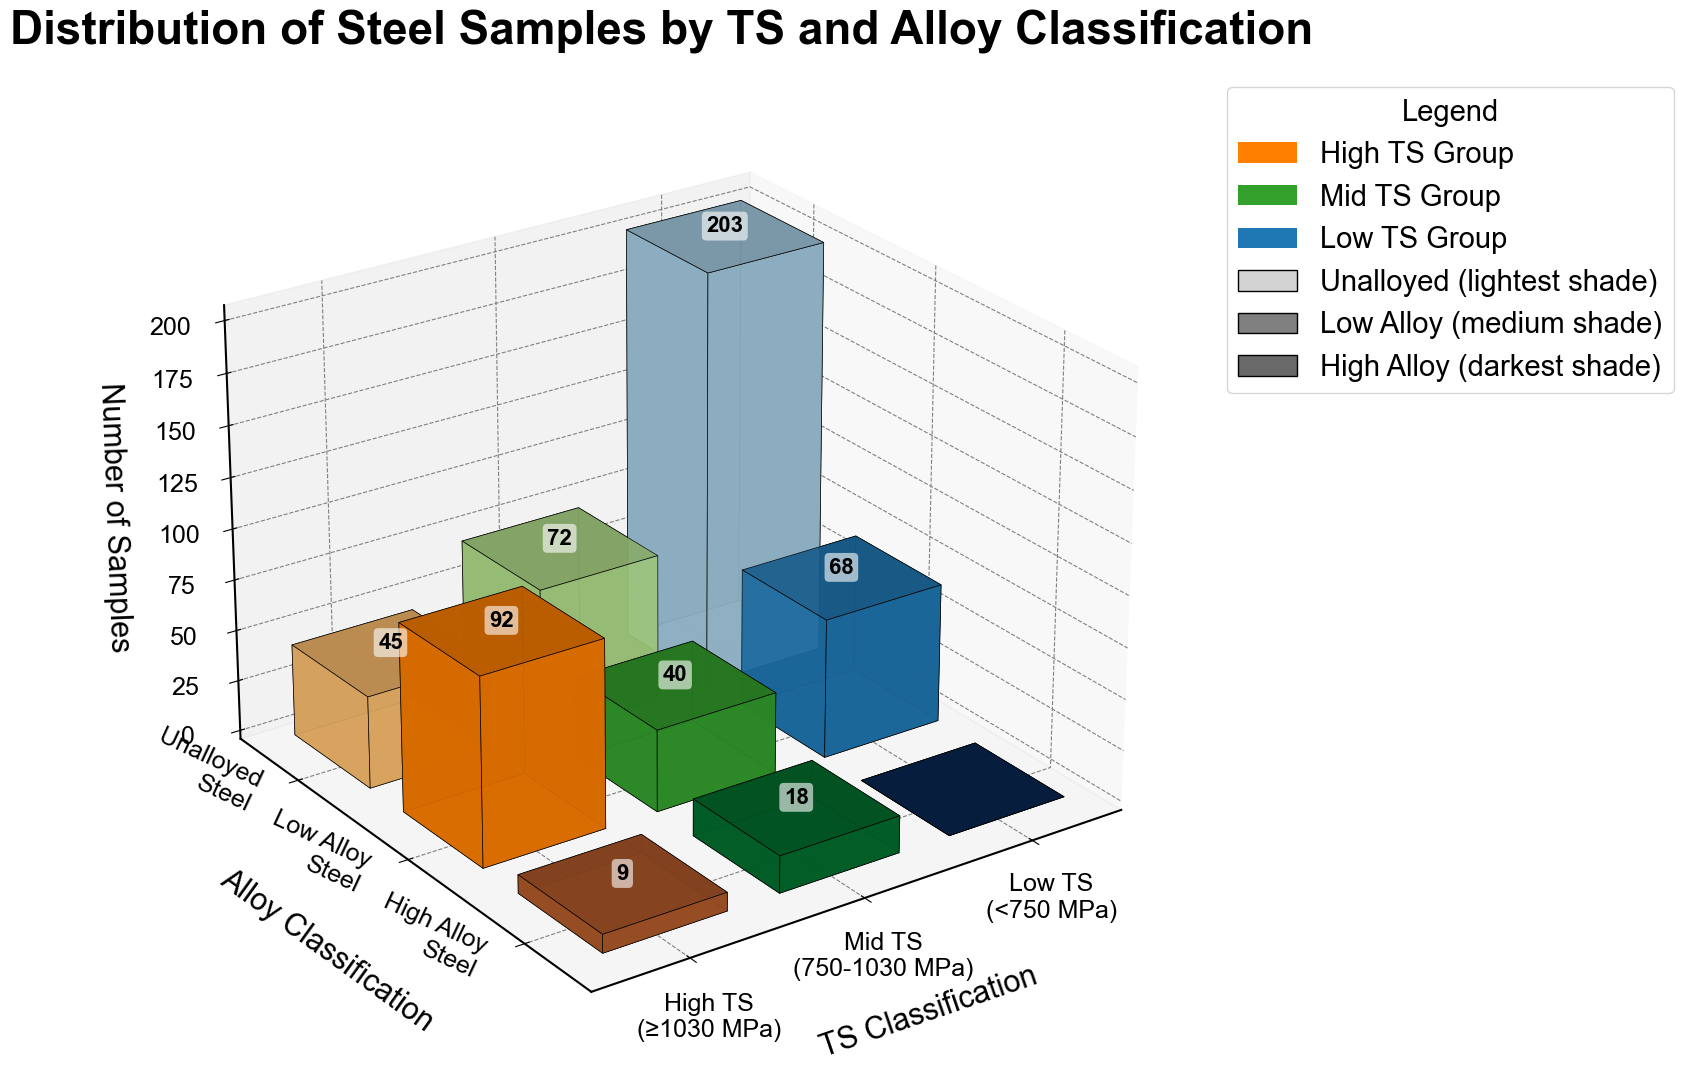


=== 상세 분석 결과 ===
  lowTS: 271개 (49.5%)
  midTS: 130개 (23.8%)
  highTS: 146개 (26.7%)

=== 추가 시각화: 산점도 분석 (Nature 스타일 적용) ===


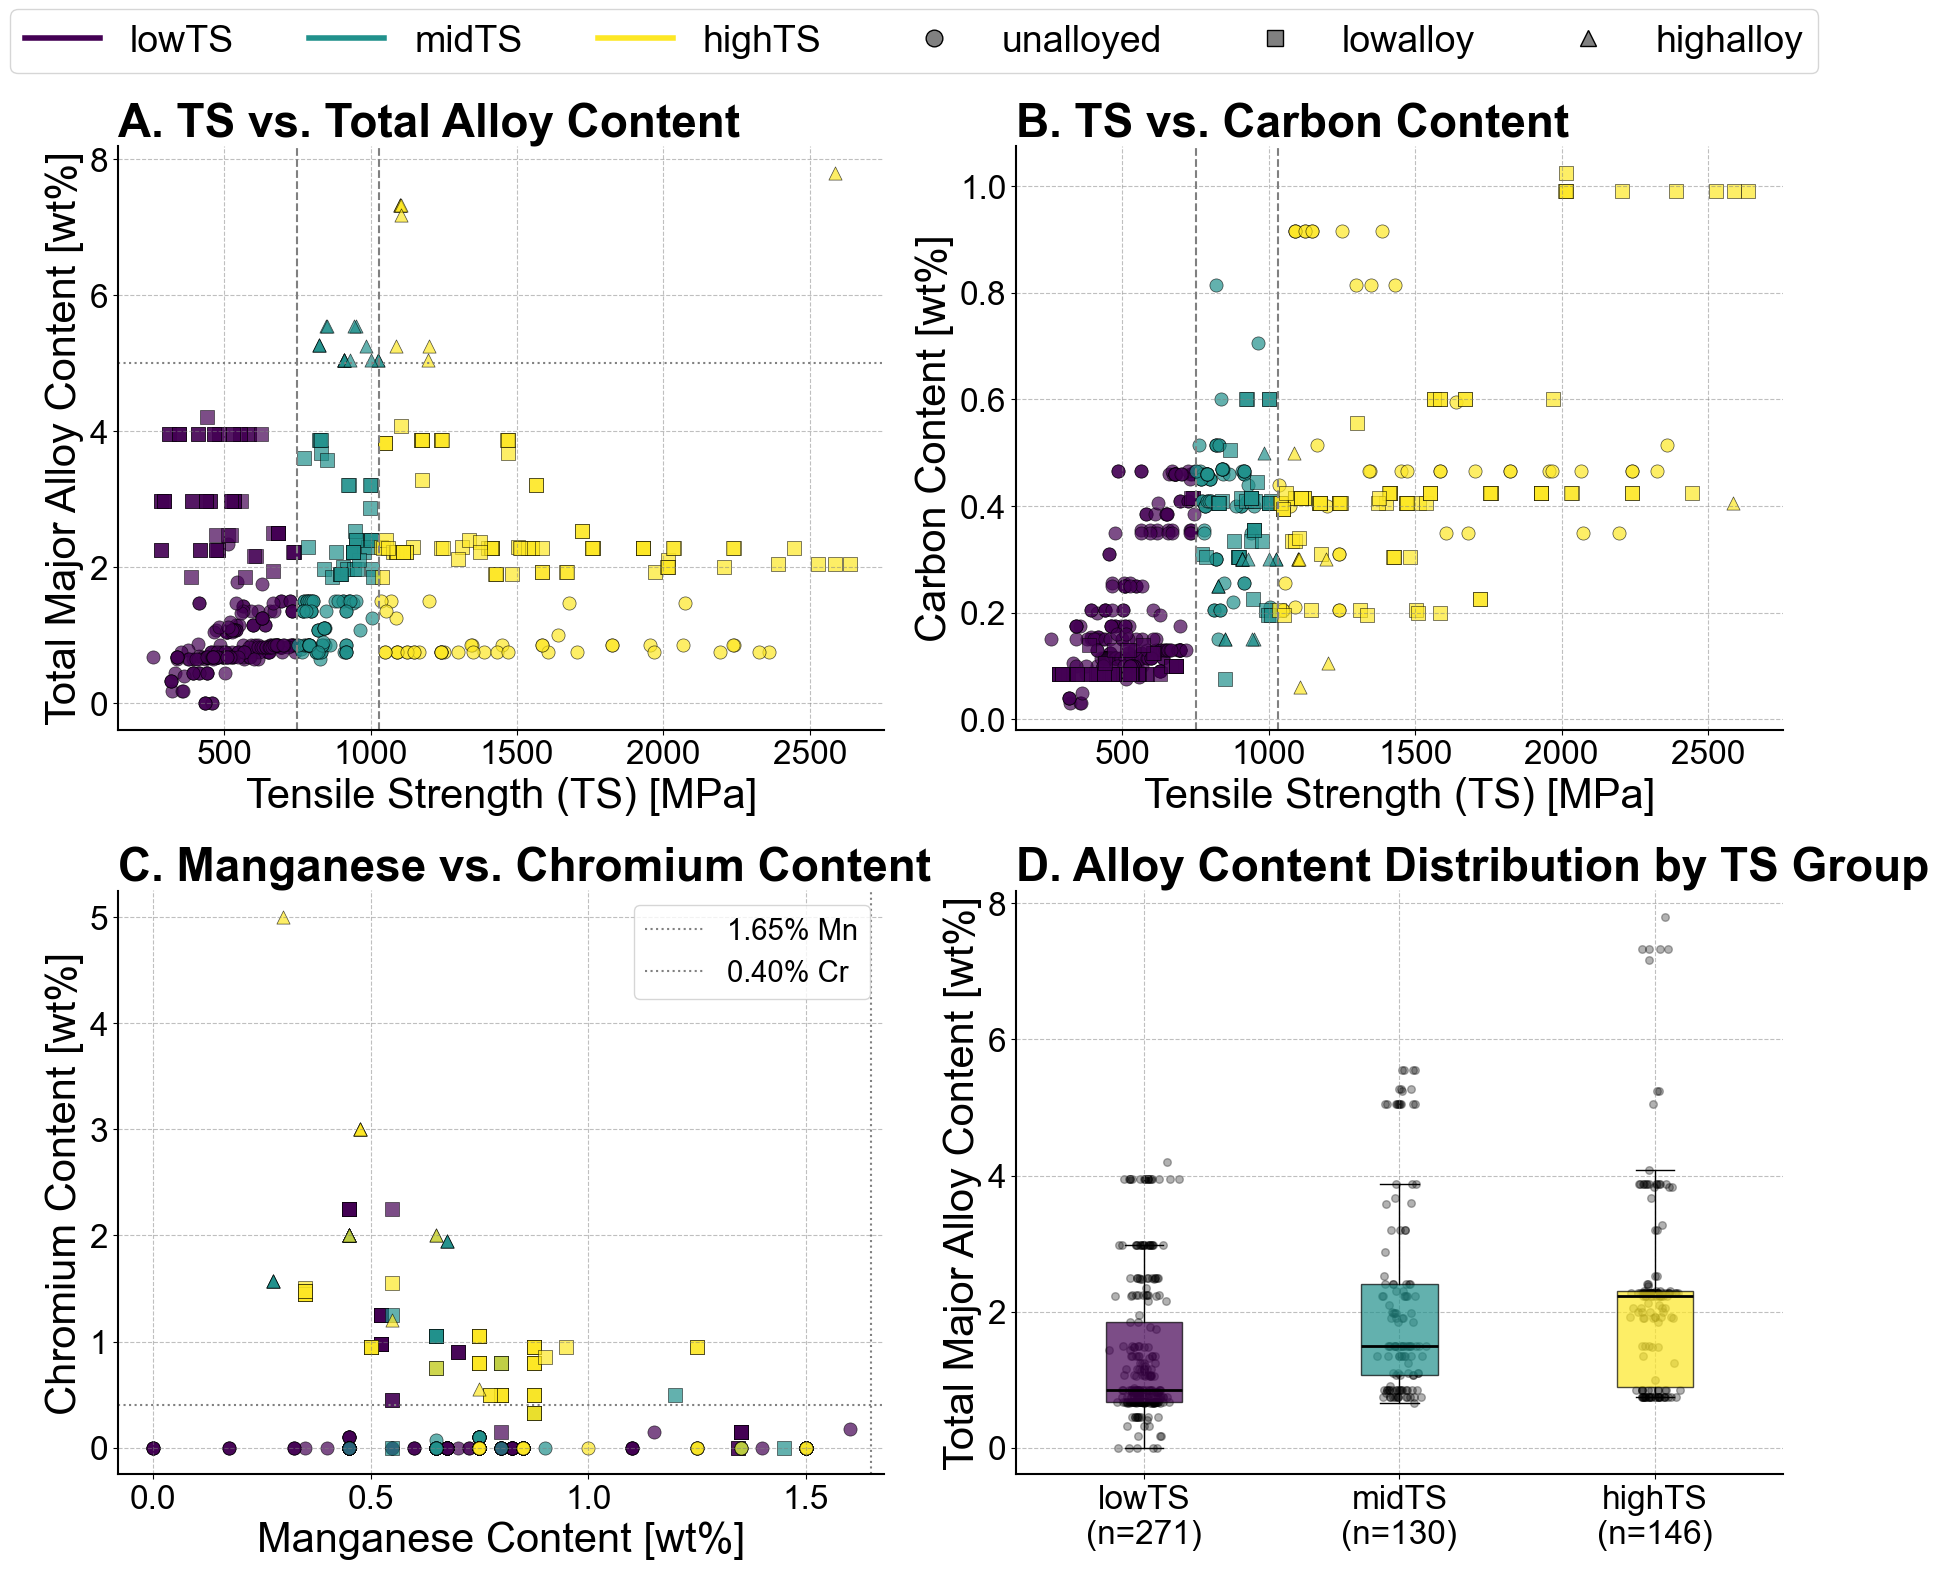


📍 범례 설명:
  색상 - TS 그룹: 🔴 lowTS (<750), 🟢 midTS (750-1030), 🔵 highTS (≥1030)
  마커 - 합금타입: ● unalloyed, ■ lowalloy, ▲ highalloy

📊 주요 통계:
  평균 TS: 870.0 ± 466.6 MPa
  평균 총 합금원소: 1.79 ± 1.34 wt%
  평균 탄소함량: 0.305 ± 0.198 wt%


In [1]:
# 3차원 그래프: TS 분류 vs 합금 분류 vs 샘플 수 (수정된 버전)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

# === Nature 저널 스타일을 위한 Matplotlib 전역 설정 ===

# 1. 폰트 설정 (Sans-serif 계열 추천)
# Nature와 같은 저널에서는 명확성을 위해 Sans-serif 폰트(예: Arial, Helvetica)를 권장합니다.
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['mathtext.fontset'] = 'dejavusans' # 수식 폰트

# 만약 'Times New Roman' (Serif) 계열을 반드시 사용해야 한다면, 
# 아래 3줄의 주석을 해제하고 위의 3줄을 주석 처리하세요.
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Times New Roman', 'Times', 'DejaVu Serif', 'serif']
# plt.rcParams['mathtext.fontset'] = 'stix'

# 2. 전역 폰트 크기 및 플롯 요소 스타일 설정 (1.5배 확대)
plt.rcParams['font.size'] = 21
plt.rcParams['axes.labelsize'] = 27
plt.rcParams['axes.titlesize'] = 33
plt.rcParams['xtick.labelsize'] = 21
plt.rcParams['ytick.labelsize'] = 21
plt.rcParams['legend.fontsize'] = 21
plt.rcParams['figure.titlesize'] = 36

# 3. 플롯 요소 스타일
plt.rcParams['axes.linewidth'] = 1.5      # 축 선 두께
plt.rcParams['lines.linewidth'] = 2.0     # 라인 두께
plt.rcParams['grid.linestyle'] = '--'     # 그리드 스타일
plt.rcParams['grid.color'] = 'gray'       # 그리드 색상
plt.rcParams['grid.alpha'] = 0.5          # 그리드 투명도
plt.rcParams['savefig.dpi'] = 300         # 저장 시 해상도
plt.rcParams['savefig.format'] = 'png'    # 저장 기본 포맷

def calculate_average_composition(row, element):
    """
    각 원소의 Min, Max 값의 평균을 계산
    비어있는 셀은 0으로 처리
    """
    min_col = f"{element}_Min"
    max_col = f"{element}_Max"
    
    min_val = row[min_col] if pd.notna(row[min_col]) else 0
    max_val = row[max_col] if pd.notna(row[max_col]) else 0
    
    return (min_val + max_val) / 2

def classify_alloy_type(composition_row):
    """
    ISO 4948 기준으로 합금 타입 분류
    """
    # Unalloyed Steel 기준 체크
    unalloyed_criteria = {
        'Mn': 1.65,  # 망간 1.65% 이하
        'Si': 0.60,  # 실리콘 0.60% 이하  
        'Cu': 0.60,  # 구리 0.60% 이하
    }
    
    # 기타 합금 원소 (크롬, 니켈, 몰리브덴 등) 0.40% 이하
    other_elements = ['Cr', 'Ni', 'Mo', 'V', 'Nb', 'Ti', 'Al']
    
    # 탄소 함량 체크 (2% 이하)
    carbon_content = composition_row['C']
    if carbon_content > 2.0:
        return 'highalloy'  # 탄소 함량이 2% 초과면 고합금강
    
    # Unalloyed Steel 기준 체크
    is_unalloyed = True
    
    # 망간, 실리콘, 구리 기준 체크
    for element, limit in unalloyed_criteria.items():
        if composition_row[element] > limit:
            is_unalloyed = False
            break
    
    # 기타 합금 원소 기준 체크 (각각 0.40% 이하)
    if is_unalloyed:
        for element in other_elements:
            if composition_row[element] > 0.40:
                is_unalloyed = False
                break
    
    if is_unalloyed:
        return 'unalloyed'
    
    # 합금 원소 총합 계산 (탄소 제외)
    # 주요 합금 원소들의 총합
    alloy_elements = ['Mn', 'Si', 'Ni', 'Cr', 'Mo', 'Cu', 'V', 'Nb', 'Ti', 'Al']
    total_alloy_content = sum(composition_row[element] for element in alloy_elements)
    
    # Low-alloy vs High-alloy 구분
    if total_alloy_content <= 5.0:
        return 'lowalloy'
    else:
        return 'highalloy'

def classify_ts_group(ts_value):
    """TS 기준으로 그룹 분류"""
    if ts_value < 750:
        return 'lowTS'
    elif 750 <= ts_value < 1030:
        return 'midTS'
    else:
        return 'highTS'

print("=== 3D 분석: TS 분류 vs 합금 분류 vs 샘플 수 (수정된 버전) ===")

try:
    # composition 시트에서 데이터 로드 (main과 composition을 동일하게)
    df_composition = pd.read_excel('TrainSet0507_NoDuplicatesHV.xlsx', sheet_name='composition')
    print(f"composition 데이터 로드 완료: {df_composition.shape[0]}개 행, {df_composition.shape[1]}개 열")
    
    # 원소 목록 (Min, Max 컬럼이 있는 원소들)
    elements = ['C', 'Mn', 'P', 'S', 'Si', 'Ni', 'Cr', 'Mo', 'Cu', 'V', 'B', 'Al', 'N', 'Nb', 'Ti']
    
    # 각 원소별로 평균 성분 계산
    for element in elements:
        df_composition[element] = df_composition.apply(lambda row: calculate_average_composition(row, element), axis=1)
    
    # TS 컬럼을 숫자형으로 변환 (문자열 제거)
    df_composition['TS'] = pd.to_numeric(df_composition['TS'], errors='coerce')
    
    # 합금 타입 분류
    df_composition['alloy_type'] = df_composition.apply(lambda row: classify_alloy_type(row), axis=1)
    
    # TS와 alloy_type을 모두 포함하여 결측값 제거 (인덱스 문제 해결)
    df_clean = df_composition[['TS', 'alloy_type']].dropna()
    print(f"TS와 alloy_type 모두 유효한 데이터: {len(df_clean)}개 샘플")
    
    # TS 기준 분류 추가
    df_clean['ts_group'] = df_clean['TS'].apply(classify_ts_group)
    
    # 축 라벨 정의 (전역 변수로)
    ts_groups = ['lowTS', 'midTS', 'highTS']
    alloy_types = ['unalloyed', 'lowalloy', 'highalloy']
    
    print(f"최종 분석 데이터: {len(df_clean)}개 샘플")
    
    # 주요 합금 원소 총합 계산 (미리 계산)
    major_alloy_elements = ['Mn', 'Si', 'Ni', 'Cr', 'Mo', 'Cu']
    df_composition['total_major_alloy'] = df_composition[major_alloy_elements].sum(axis=1)
    
    print("데이터 전처리 완료!")
    
except Exception as e:
    print(f"데이터 로딩 및 전처리 중 오류: {e}")
    import traceback
    traceback.print_exc()

# 3D 바 차트 생성

# --- 수정 1: TS 축 순서 반전 ---
# 요청에 따라 TS 축의 순서를 high -> mid -> low 로 정렬하기 위해 리스트를 뒤집습니다.
# 중요: 이 코드는 try 블록 밖에 위치해야 합니다.
ts_groups_reversed = ts_groups[::-1]

# --- 수정 2: Alloy 축 순서 반전 ---
# Alloy 타입 순서를 high -> low -> unalloy 로 수정
alloy_types_reversed = alloy_types[::-1]

try:
    # 그룹별 샘플 수 계산
    group_counts = df_clean.groupby(['ts_group', 'alloy_type']).size().reset_index(name='count')
    
    print("\n=== 그룹별 샘플 수 ===")
    for _, row in group_counts.iterrows():
        print(f"{row['ts_group']} + {row['alloy_type']}: {row['count']}개")

    # 전문적인 색상 팔레트 정의
    colors = {
        ('lowTS', 'unalloyed'): '#a6cee3', ('lowTS', 'lowalloy'): '#1f78b4', ('lowTS', 'highalloy'): '#08306b',
        ('midTS', 'unalloyed'): '#b2df8a', ('midTS', 'lowalloy'): '#33a02c', ('midTS', 'highalloy'): '#006d2c',
        ('highTS', 'unalloyed'): '#fdbf6f', ('highTS', 'lowalloy'): '#ff7f00', ('highTS', 'highalloy'): '#b15928',
    }
    
    # 3D 플롯 생성
    fig = plt.figure(figsize=(16, 13))
    ax = fig.add_subplot(111, projection='3d')
    
    # 좌표 및 높이 데이터 준비 (수정된 ts_groups_reversed와 alloy_types_reversed 사용)
    x_coords, y_coords, heights, bar_colors = [], [], [], []
    for i, ts_group in enumerate(ts_groups_reversed): # reversed list 사용
        for j, alloy_type in enumerate(alloy_types_reversed): # reversed list 사용
            count_val = group_counts[(group_counts['ts_group'] == ts_group) & (group_counts['alloy_type'] == alloy_type)]['count'].values
            count = count_val[0] if len(count_val) > 0 else 0
            x_coords.append(i)
            y_coords.append(j)
            heights.append(count)
            bar_colors.append(colors.get((ts_group, alloy_type), '#DDDDDD'))

    # 3D 바 차트 생성
    dx = dy = 0.7
    ax.bar3d(x_coords, y_coords, [0]*len(heights), dx, dy, heights, color=bar_colors, alpha=0.9, edgecolor='black', linewidth=0.5)

    # 바 위에 숫자 표시
    for x, y, h in zip(x_coords, y_coords, heights):
        if h > 5: 
            ax.text(x + dx/2, y + dy/2, h, f'{int(h)}', ha='center', va='bottom', fontsize=16, fontweight='bold',
                    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2'))

    # 축 레이블 간격 조정
    ax.set_xlabel('TS Classification', fontsize=22, labelpad=40)
    ax.set_ylabel('Alloy Classification', fontsize=22, labelpad=35)
    ax.set_zlabel('Number of Samples', fontsize=22, labelpad=30)
    
    # --- 수정 2: TS 축 레이블 순서 반전 ---
    # 데이터 순서가 high -> mid -> low로 변경되었으므로, 레이블도 동일한 순서로 지정합니다.
    ax.set_xticks(np.arange(len(ts_groups_reversed)) + dx/2)
    ax.set_xticklabels([f'High TS\n(≥1030 MPa)', f'Mid TS\n(750-1030 MPa)', f'Low TS\n(<750 MPa)'], fontsize=18)
    
    # Alloy 축 레이블 설정 (순서는 high -> low -> unalloy 로 수정)
    ax.set_yticks(np.arange(len(alloy_types_reversed)) + dy/2)
    ax.set_yticklabels([f'High Alloy\nSteel', f'Low Alloy\nSteel', f'Unalloyed\nSteel'], 
                       fontsize=18, rotation=-25, va='bottom', ha='right') # 회전각 및 정렬 수정
    
    # --- 수정 3: Alloy(Y) 축 틱과 레이블 사이 간격 조정 ---
    # pad 값을 늘려 틱 레이블이 그래프와 충분히 떨어지도록 합니다.
    ax.tick_params(axis='x', pad=10)
    ax.tick_params(axis='y', pad=15) # 기존 5에서 15로 증가
    ax.tick_params(axis='z', pad=15)
    ax.tick_params(axis='z', labelsize=18)

    # 제목
    ax.set_title('Distribution of Steel Samples by TS and Alloy Classification', 
                 fontweight='bold', pad=20)
    
    # 레이아웃 및 뷰 개선
    ax.view_init(elev=25, azim=-125)
    
    # 범례 생성 (이전과 동일)
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#ff7f00', label='High TS Group'), # 범례 순서도 데이터에 맞게 수정
        Patch(facecolor='#33a02c', label='Mid TS Group'),
        Patch(facecolor='#1f78b4', label='Low TS Group'),
        Patch(facecolor='lightgray', edgecolor='black', label='Unalloyed (lightest shade)'),
        Patch(facecolor='gray', edgecolor='black', label='Low Alloy (medium shade)'),
        Patch(facecolor='dimgray', edgecolor='black', label='High Alloy (darkest shade)'),
    ]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), title="Legend")
    
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()
    
    # 고해상도 이미지로 저장
    # fig.savefig("Fig1_3D_Distribution_v3.pdf", bbox_inches='tight')
    
    # (이하 통계 출력 코드는 동일)
    print(f"\n=== 상세 분석 결과 ===")
    ts_counts = df_clean['ts_group'].value_counts()
    for ts_group in ts_groups:
        count = ts_counts.get(ts_group, 0)
        print(f"  {ts_group}: {count}개 ({(count / len(df_clean)) * 100:.1f}%)")

except Exception as e:
    print(f"3D 플롯 생성 중 오류: {e}")
    import traceback
    traceback.print_exc()

# 추가 시각화: 산점도 (Scatter Plot)
try:
    print(f"\n=== 추가 시각화: 산점도 분석 (Nature 스타일 적용) ===")
    
    # 필요한 변수들 정의 (이전 셀에서 정의되지 않은 경우 대비)
    if 'ts_groups' not in globals():
        ts_groups = ['lowTS', 'midTS', 'highTS']
    if 'alloy_types' not in globals():
        alloy_types = ['unalloyed', 'lowalloy', 'highalloy']
    if 'major_alloy_elements' not in globals():
        major_alloy_elements = ['Mn', 'Si', 'Ni', 'Cr', 'Mo', 'Cu']
    
    # 필요한 경우 합금 원소 총합 계산
    if 'total_major_alloy' not in df_composition.columns:
        df_composition['total_major_alloy'] = df_composition[major_alloy_elements].sum(axis=1)
    
    # 데이터 준비 코드는 원본 유지
    df_clean = df_clean.copy() # SettingWithCopyWarning 방지
    df_clean['total_major_alloy'] = df_composition.loc[df_clean.index, 'total_major_alloy']
    df_clean['carbon_content'] = df_composition.loc[df_clean.index, 'C']
    df_clean['manganese_content'] = df_composition.loc[df_clean.index, 'Mn']
    df_clean['chromium_content'] = df_composition.loc[df_clean.index, 'Cr']

    # 1. 전문적인 색상 및 마커 팔레트 정의
    from matplotlib.cm import get_cmap
    viridis = get_cmap('viridis', 3)
    ts_colors = {'lowTS': viridis(0.1), 'midTS': viridis(0.5), 'highTS': viridis(0.9)}
    alloy_markers = {'unalloyed': 'o', 'lowalloy': 's', 'highalloy': '^'}

    # 2x2 서브플롯 생성
    fig, axes = plt.subplots(2, 2, figsize=(18, 16))
    
    # --- A. TS vs 총 합금 원소 함량 ---
    ax = axes[0, 0]
    for ts_group in ts_groups:
        for alloy_type in alloy_types:
            subset = df_clean[(df_clean['ts_group'] == ts_group) & (df_clean['alloy_type'] == alloy_type)]
            if not subset.empty:
                ax.scatter(subset['TS'], subset['total_major_alloy'],
                           c=[ts_colors[ts_group]], marker=alloy_markers[alloy_type],
                           s=90, alpha=0.7, edgecolors='k', linewidth=0.5)
    ax.axvline(x=750, c='gray', ls='--', lw=1.5)
    ax.axvline(x=1030, c='gray', ls='--', lw=1.5)
    ax.axhline(y=5.0, c='gray', ls=':', lw=1.5, label='5% Alloy')
    ax.set_xlabel('Tensile Strength (TS) [MPa]', fontsize=30)
    ax.set_ylabel('Total Major Alloy Content [wt%]', fontsize=30)
    ax.set_title('A. TS vs. Total Alloy Content', loc='left', fontweight='bold')

    # --- B. TS vs 탄소 함량 ---
    ax = axes[0, 1]
    for ts_group in ts_groups:
        for alloy_type in alloy_types:
            subset = df_clean[(df_clean['ts_group'] == ts_group) & (df_clean['alloy_type'] == alloy_type)]
            if not subset.empty:
                ax.scatter(subset['TS'], subset['carbon_content'],
                           c=[ts_colors[ts_group]], marker=alloy_markers[alloy_type],
                           s=90, alpha=0.7, edgecolors='k', linewidth=0.5)
    ax.axvline(x=750, c='gray', ls='--', lw=1.5)
    ax.axvline(x=1030, c='gray', ls='--', lw=1.5)
    ax.set_xlabel('Tensile Strength (TS) [MPa]', fontsize=30)
    ax.set_ylabel('Carbon Content [wt%]', fontsize=30)
    ax.set_title('B. TS vs. Carbon Content', loc='left', fontweight='bold')

    # --- C. 망간 vs 크롬 함량 ---
    ax = axes[1, 0]
    for ts_group in ts_groups:
        for alloy_type in alloy_types:
            subset = df_clean[(df_clean['ts_group'] == ts_group) & (df_clean['alloy_type'] == alloy_type)]
            if not subset.empty:
                ax.scatter(subset['manganese_content'], subset['chromium_content'],
                           c=[ts_colors[ts_group]], marker=alloy_markers[alloy_type],
                           s=90, alpha=0.7, edgecolors='k', linewidth=0.5)
    ax.axvline(x=1.65, c='gray', ls=':', lw=1.5, label='1.65% Mn')
    ax.axhline(y=0.40, c='gray', ls=':', lw=1.5, label='0.40% Cr')
    ax.set_xlabel('Manganese Content [wt%]', fontsize=30)
    ax.set_ylabel('Chromium Content [wt%]', fontsize=30)
    ax.set_title('C. Manganese vs. Chromium Content', loc='left', fontweight='bold')
    ax.legend()
    
    # --- D. TS 그룹별 박스플롯 (총 합금 원소) ---
    ax = axes[1, 1]
    box_data = [df_clean[df_clean['ts_group'] == g]['total_major_alloy'].dropna() for g in ts_groups]
    bp = ax.boxplot(box_data, patch_artist=True, showfliers=False,
                    labels=[f'{g}\n(n={len(d)})' for g, d in zip(ts_groups, box_data)])
    for patch, color in zip(bp['boxes'], ts_colors.values()):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    for median in bp['medians']:
        median.set(color='black', linewidth=2)
    for i, d in enumerate(box_data):
        x_coords = np.random.normal(i + 1, 0.04, len(d))
        ax.scatter(x_coords, d, alpha=0.3, s=30, color='black', zorder=0)
    ax.set_ylabel('Total Major Alloy Content [wt%]', fontsize=30)
    ax.set_title('D. Alloy Content Distribution by TS Group', loc='left', fontweight='bold')
    
    # 모든 서브플롯 스타일 통일
    for ax in axes.flatten():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=24)
        ax.grid(True)

    # 통합 범례 생성
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color=c, lw=4, label=g) for g, c in ts_colors.items()
    ] + [
        Line2D([0], [0], marker=m, color='w', label=a, linestyle='None', 
               markersize=12, markeredgecolor='k', markerfacecolor='gray') for a, m in alloy_markers.items()
    ]
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=len(legend_elements), fontsize=27)

    plt.tight_layout(rect=[0, 0, 1, 0.95]) # 범례 공간 확보
    plt.show()

    # 이미지 저장
    # fig.savefig("Fig2_Scatter_Analysis.pdf", bbox_inches='tight')
    # fig.savefig("Fig2_Scatter_Analysis.png", bbox_inches='tight', dpi=300)
    
    # 범례 설명
    print(f"\n📍 범례 설명:")
    print(f"  색상 - TS 그룹: 🔴 lowTS (<750), 🟢 midTS (750-1030), 🔵 highTS (≥1030)")
    print(f"  마커 - 합금타입: ● unalloyed, ■ lowalloy, ▲ highalloy")
    
    # 통계 요약
    print(f"\n📊 주요 통계:")
    print(f"  평균 TS: {df_clean['TS'].mean():.1f} ± {df_clean['TS'].std():.1f} MPa")
    print(f"  평균 총 합금원소: {df_clean['total_major_alloy'].mean():.2f} ± {df_clean['total_major_alloy'].std():.2f} wt%")
    print(f"  평균 탄소함량: {df_clean['carbon_content'].mean():.3f} ± {df_clean['carbon_content'].std():.3f} wt%")
    
except Exception as e:
    print(f"산점도 생성 중 오류: {e}")
    import traceback
    traceback.print_exc()
